In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

route_name = "hatoma_route"
dep = "hatoma_dep"
days_ago = 1
#taketomi_route isigaki_dep 1
def df_load(route_name,dep,days_ago):
    """
    学習するためのdfを作成する。
    前処理が終わった後のdf
    parameters
    ----------
    days_ago:str
        教師ラベルと説明変数を何日ずらしているか
        
    return
    ------
    X:dataframe
       説明変数のdf
    y:dataframe
       目的変数(教師ラベル)のdf 
    """
    #'../data/df_com_all_2/'+route_name+'_'+i+'_'+str(days_ago)+'.csv'
    df = pd.read_csv('../data/df_com_all_3/'+route_name+'_'+dep+'_'+str(days_ago)+'.csv', header=None)

    df = df.dropna(subset=[1])

    #データのロード
    X = df.iloc[:,3:12].values
    #print(X)
    y = df.loc[:, 1]#.values
    #print(y)
    return X,y
X,y = df_load(route_name,dep,days_ago)

In [2]:
df

NameError: name 'df' is not defined

In [3]:
#データの分割（テスト用とトレーニング用）
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)
print('Labels counts in y[0 1]:', np.bincount(y))
print('Labels counts in y_train[0 1]:', np.bincount(y_train))
print('Labels counts in y_test[0 1]:', np.bincount(y_test))

Labels counts in y[0 1]: [4821  857]
Labels counts in y_train[0 1]: [3856  686]
Labels counts in y_test[0 1]: [965 171]


In [4]:
print(y)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5783    0.0
5784    0.0
5785    0.0
5786    0.0
5788    1.0
Name: 1, Length: 5678, dtype: float64


In [5]:
#標準化
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print(X_train_std)

[[ 0.30772341 -0.58799458 -0.68480415 ... -0.61041076 -0.75240162
  -0.64455129]
 [-0.26266499  1.81575242  0.78201049 ... -0.09134019  0.9752393
  -1.26165753]
 [-0.26266499  0.00648048  0.04860317 ... -0.48064312 -0.29992424
  -0.49027474]
 ...
 [ 0.30772341  0.32956476  1.0264796  ...  0.55749802  0.95467214
   0.43538462]
 [ 0.30772341 -0.2261402   0.78201049 ...  0.03842745  0.39935899
   0.1268315 ]
 [-1.2893641  -0.1356766  -0.92927326 ... -1.12948134  0.62559768
  -1.57021065]]


In [19]:
import lightgbm as lgb
def train_data(X_train, y_train,lgb):
    """学習用データの作成
        Args:
            X_train:
                学習用のトレーニングデータ
            y_train:
                学習用のラベルデータ

        Returns:
            lgb.Dataset(X_train, label=y_train):
                学習用データの作成
    """
    return lgb.Dataset(X_train, label=y_train)

train_data=train_data(X_train, y_train,lgb)

In [20]:
# テストデータの作成    
def test_data(X_test, y_test, train_data,lgb):
    """テストデータの作成
        Args:
            X_test:
                学習用のtestデータ
            y_test:
                学習用のtestデータ

        Returns:
            lgb.Dataset(X_test, label=y_test, reference=train_data):
                学習用データの作成
    """
    return lgb.Dataset(X_test, label=y_test, reference=train_data)
test_data = test_data(X_test, y_test, train_data,lgb)

In [21]:
def par():
    """
    パラメータの辞書を返す
    """
    boostring='dart'
    learning_rate=0.05
    min_data_in_leaf=20
    #applications='binary'
    feature_fraction=0.7
    num_leaves=41
    metric='auc'#'binary_logloss'#'auc'
    drop_date=0.15
    objective = "binary"
    #application = applications
    parameters = {
                'boosting': boostring,          # dart (drop out trees) often performs better
                'objective': objective,
                #'application': applications,     # Binary classification
                'learning_rate': learning_rate,       # Learning rate, controls size of a gradient descent step
                'min_data_in_leaf': min_data_in_leaf,      # Data set is quite small so reduce this a bit
                'feature_fraction': feature_fraction,     # Proportion of features in each boost, controls overfitting
                'num_leaves': num_leaves,            # Controls size of tree since LGBM uses leaf wise splits
                'metric': metric,  # Area under ROC curve as the evaulation metric
                'drop_rate': drop_date   
            }
    return parameters
parameters = par()

In [22]:
def fit(train_data, test_data, parameters, batch=100):
    """学習を行う
        Args:
            train_data:
                学習用trainデータ
            test_data:
                学習用testデータ
            batch:
                学習回数
                初期値は100
    """
    evaluation_results = {}
    model=lgb.train(parameters,
                    train_data,
                    valid_sets=[train_data, test_data], 
                    valid_names=['Train', 'Test'],
                    evals_result = evaluation_results,
                    num_boost_round=batch,
                    early_stopping_rounds=50,
                    verbose_eval=20)
    return model,evaluation_results
    #optimum_boost_rounds = self.model.best_iteration
model,evaluation_results = fit(train_data, test_data, parameters, batch=100)

[LightGBM] [Info] Number of positive: 686, number of negative: 3856
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 4542, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151035 -> initscore=-1.726508
[LightGBM] [Info] Start training from score -1.726508
[20]	Train's auc: 0.918199	Test's auc: 0.879399
[40]	Train's auc: 0.926029	Test's auc: 0.885174
[60]	Train's auc: 0.930216	Test's auc: 0.889368

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[80]	Train's auc: 0.932454	Test's auc: 0.890283
[100]	Train's auc: 0.933809	Test's auc: 0.891677


In [23]:
def predict(model,X_test):
    """予測を行う
        Args:
            X_test:
                予測をしたいデータ
        Returns:
            model.predict(X_test):
                予測結果
    """
    return model.predict(X_test)
y_pred_proba = predict(model,X_test)
#print(y_pred_proba)
y_pred = [0 if i < 0.5 else 1 for i in y_pred_proba]
print(y_pred)
y_train_proba = predict(model,X_train)
y_pred_train = [0 if i < 0.5 else 1 for i in y_train_proba]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

def accuracy_rate(y_test,y_pred):
    """予測結果から正解率を表示
        Args:
            y_test:
                予測に使用したデータのラベル(目的変数)
            y_pred:
                予測結果
    """
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print("AUC",auc)

y_pred = pd.Series(y_pred)
#print(y_test,y_pred)
#print(y_test)
#print(y_pred_proba)
accuracy_rate(y_test,y_pred_proba)
accuracy_rate(y_test,y_pred)
accuracy_rate(y_train,y_pred_train)
#print('Test Accuracy: %.3f' % model.score(X_test, y_test))
print(accuracy_score(y_test, y_pred))
print(y_pred)

AUC 0.8916765142562797
AUC 0.5826864224464443
AUC 0.61492823270387
0.8591549295774648
0       0
1       0
2       0
3       0
4       0
       ..
1131    0
1132    0
1133    0
1134    0
1135    0
Length: 1136, dtype: int64


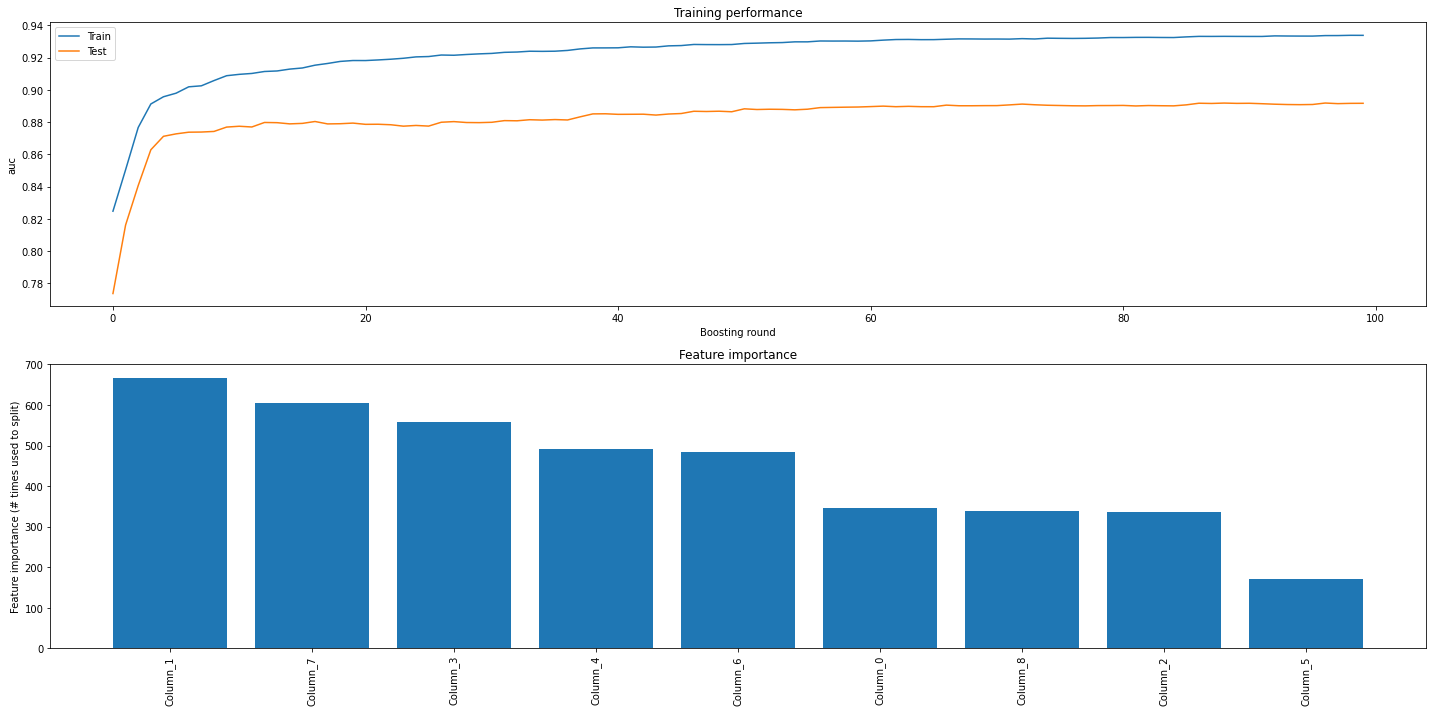

In [25]:
import matplotlib.pyplot as plt
def plot_imp():
    """学習後にtrain,testそれぞれの学習回数ごとのAccuracyグラフと特徴量の重要度のグラフ表示
    """
    fig, axs = plt.subplots(2, 1, figsize=[20, 10])

    # Plot the log loss during training
    axs[0].plot(evaluation_results['Train']['auc'], label='Train')
    axs[0].plot(evaluation_results['Test']['auc'], label='Test')
    axs[0].set_ylabel('auc')
    axs[0].set_xlabel('Boosting round')
    axs[0].set_title('Training performance')
    axs[0].legend()

    # Plot feature importance
    importances = pd.DataFrame({'features': model.feature_name(), 
                                'importance': model.feature_importance()}).sort_values('importance', ascending=False)
    axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
    axs[1].set_xticks(np.arange(len(importances)))
    axs[1].set_xticklabels(importances['features'])
    axs[1].set_ylabel('Feature importance (# times used to split)')
    axs[1].set_title('Feature importance')

    plt.xticks(rotation=90)
    plt.tight_layout()
    #plt.show()
    plt.savefig("重要度.png")

plot_imp()

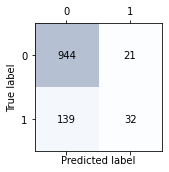

[[944  21]
 [139  32]]
[[944  21]
 [139  32]]


In [38]:
#混同行列
from sklearn.metrics import confusion_matrix

def confm(route_name,dep,days_ago,y_pred,y_test):
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    

    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.savefig('../data/images_conf/'+route_name+'_'+dep+'_'+str(days_ago)+'.png', dpi=300)
    plt.show()
    print(confmat)
    
    return confmat
confmat = confm(route_name,dep,days_ago,y_pred,y_test)
print(confmat)

In [47]:
print(type(y_test))

<class 'pandas.core.series.Series'>


In [42]:
#適合率、再現率、F1スコア
from sklearn.metrics import precision_score, recall_score, f1_score

path_w = "../data/result_value/1_30_value.txt"
with open(path_w, mode='a') as f:
    f.writelines('Accuracy : %.3f\n' % accuracy_score(y_test, y_pred))
    f.writelines('Precision: %.3f\n' % precision_score(y_true=y_test, y_pred=y_pred))
    f.writelines('Recall: %.3f\n' % recall_score(y_true=y_test, y_pred=y_pred))
    f.writelines('F1: %.3f\n' % f1_score(y_true=y_test, y_pred=y_pred))
    f.writelines(str(confmat)+"\n")
    
print(accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))
print(confmat)

def result_txt(path_txt,route_name,dep,days_ago,confmat=False,y_test=False, y_pred=False, e=True):
    if e == True:
        with open(path_txt, mode='a') as f:                   #追記"a"
            f.writelines('出発航路'+route_name+' 出発港'+dep+' 日にち '+str(days_ago)+'日前 \n')
            f.writelines("欠航データなし\n")
#             f.writelines('Labels counts in y[0 1]:', np.bincount(y))
#             f.writelines('Labels counts in y_train[0 1]:', np.bincount(y_train))
#             f.writelines('Labels counts in y_test[0 1]:', np.bincount(y_test))

    else:
        with open(path_txt, mode='a') as f:                   #追記"a"
            f.writelines('出発航路'+route_name+' 出発港'+dep+' 日にち '+str(days_ago)+'日前 \n')
#             f.writelines('Labels counts in y[0 1]:', np.bincount(y))
#             f.writelines('Labels counts in y_train[0 1]:', np.bincount(y_train))
#             f.writelines('Labels counts in y_test[0 1]:', np.bincount(y_test))
            f.writelines('Accuracy : %.3f\n' % accuracy_score(y_test, y_pred))
            f.writelines('Precision: %.3f\n' % precision_score(y_true=y_test, y_pred=y_pred))
            f.writelines('Recall: %.3f\n' % recall_score(y_true=y_test, y_pred=y_pred))
            f.writelines('F1: %.3f\n' % f1_score(y_true=y_test, y_pred=y_pred))
            f.writelines(str(confmat)+"\n")

0.8591549295774648
Precision: 0.604
Recall: 0.187
F1: 0.286
[[944  21]
 [139  32]]


Labels counts in y[0 1]: [4821  857]
Labels counts in y_train[0 1]: [3856  686]
Labels counts in y_test[0 1]: [965 171]
[LightGBM] [Info] Number of positive: 686, number of negative: 3856
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 4542, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151035 -> initscore=-1.726508
[LightGBM] [Info] Start training from score -1.726508
[20]	Train's auc: 0.918199	Test's auc: 0.879399


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	Train's auc: 0.926029	Test's auc: 0.885174
[60]	Train's auc: 0.930216	Test's auc: 0.889368
[80]	Train's auc: 0.932454	Test's auc: 0.890283
[100]	Train's auc: 0.933809	Test's auc: 0.891677
0.8591549295774648


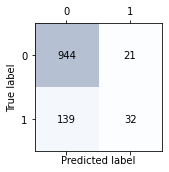

[[944  21]
 [139  32]]
No err


In [43]:
import time
import lightgbm as lgb

route_name = "hatoma_route"
dep = "hatoma_dep"
days_ago = 1
path_txt = "../data/result_value/1_30_value.txt"
def main(route_name,dep,days_ago,path_txt):
    X,y = df_load(route_name,dep,days_ago)
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1, stratify=y)
        print('Labels counts in y[0 1]:', np.bincount(y))
        print('Labels counts in y_train[0 1]:', np.bincount(y_train))
        print('Labels counts in y_test[0 1]:', np.bincount(y_test))

        #train_data = None
        #train_data = train_data(X_train, y_train,lgb)
        train_data = lgb.Dataset(X_train, label=y_train)
        #time.sleep(2)
        test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
        #test_data = test_data(X_test, y_test, train_data,lgb)

        parameters = par()

        model,evaluation_results = fit(train_data, test_data, parameters, batch=100)

        y_pred_proba = predict(model,X_test)
        y_pred = [0 if i < 0.5 else 1 for i in y_pred_proba]
        y_train_proba = predict(model,X_train)                        #確率表記のpred
        y_pred_train = [0 if i < 0.5 else 1 for i in y_train_proba]   #二値表記に直している
        print(accuracy_score(y_test, y_pred))

        confmat=confm(route_name,dep,days_ago,y_pred,y_test)
        e = False
        result_txt(path_txt,route_name,dep,days_ago,confmat,y_test, y_pred,e)
        print("No err")
    except Exception as e:
        print(e)
        err = True
        result_txt(path_txt,route_name,dep,days_ago,confmat,y_test, y_pred,err)
        
main(route_name,dep,days_ago,path_txt)


taketomi_route isigaki_dep 1
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 2
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 3
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 4
Labels counts in y[0 1]: [979]
Labels counts in y_train[0 1]: [783]
Labels counts in y_test[0 1]: [196]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 783
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 507
[LightGBM] [Info] Number of data points in the train set: 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


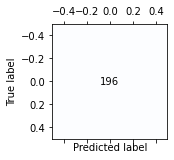

[[196]]
No err
ループ
taketomi_route isigaki_dep 5
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 6
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 7
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 8
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route isigaki_dep 9
The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
ループ
taketomi_route taketomi_dep 1
Labels counts in y[0 1]: [2076    2]
Labels counts in y_train[0 1]: [1660    2]
Labels counts in y_test[0 1]: [416]


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[80]	Train's auc: 1	Test's auc: 1
[100]	Train's auc: 1	Test's auc: 1
1.0


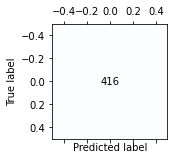

[[416]]
No err
ループ
taketomi_route taketomi_dep 2
Labels counts in y[0 1]: [2066    2]
Labels counts in y_train[0 1]: [1652    2]
Labels counts in y_test[0 1]: [414]
[LightGBM] [Info] Number of positive: 2, number of negative: 1652
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 579
[LightGBM] [Info] Number of data points in the train set: 1654, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001209 -> initscore=-6.716595
[LightGBM] [Info] Start training from score -6.716595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 1	Test's auc: 1
[40]	Train's

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[60]	Train's auc: 1	Test's auc: 1
[80]	Train's auc: 1	Test's auc: 1
[100]	Train's auc: 1	Test's auc: 1
1.0


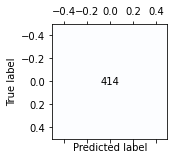

[[414]]
No err
ループ
taketomi_route taketomi_dep 3
Labels counts in y[0 1]: [2044    2]
Labels counts in y_train[0 1]: [1634    2]
Labels counts in y_test[0 1]: [410]
[LightGBM] [Info] Number of positive: 2, number of negative: 1634
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 1636, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001222 -> initscore=-6.705639
[LightGBM] [Info] Start training from score -6.705639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[100]	Train's auc: 1	Test's auc: 1
1.0


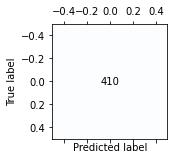

[[410]]
No err
ループ
taketomi_route taketomi_dep 4
Labels counts in y[0 1]: [2026]
Labels counts in y_train[0 1]: [1620]
Labels counts in y_test[0 1]: [406]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 1620
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 574
[LightGBM] [Info] Number of data points in the train set: 1620, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning]

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

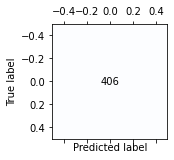

[[406]]
No err
ループ
taketomi_route taketomi_dep 5
Labels counts in y[0 1]: [2002    2]
Labels counts in y_train[0 1]: [1601    2]
Labels counts in y_test[0 1]: [401]
[LightGBM] [Info] Number of positive: 2, number of negative: 1601
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 1603, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001248 -> initscore=-6.685237
[LightGBM] [Info] Start training from score -6.685237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[100]	Train's auc: 1	Test's auc: 1
1.0


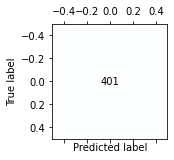

[[401]]
No err
ループ
taketomi_route taketomi_dep 6
Labels counts in y[0 1]: [1980    2]
Labels counts in y_train[0 1]: [1583    2]
Labels counts in y_test[0 1]: [397]
[LightGBM] [Info] Number of positive: 2, number of negative: 1583
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 1585, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001262 -> initscore=-6.673930
[LightGBM] [Info] Start training from score -6.673930
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[100]	Train's auc: 1	Test's auc: 1
1.0


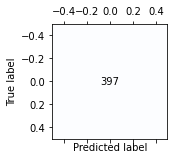

[[397]]
No err
ループ
taketomi_route taketomi_dep 7
Labels counts in y[0 1]: [1956    2]
Labels counts in y_train[0 1]: [1564    2]
Labels counts in y_test[0 1]: [392]
[LightGBM] [Info] Number of positive: 2, number of negative: 1564
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 1566, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001277 -> initscore=-6.661855
[LightGBM] [Info] Start training from score -6.661855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[100]	Train's auc: 1	Test's auc: 1
1.0


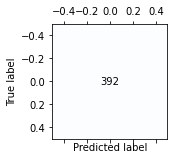

[[392]]
No err
ループ
taketomi_route taketomi_dep 8
Labels counts in y[0 1]: [1934    2]
Labels counts in y_train[0 1]: [1546    2]
Labels counts in y_test[0 1]: [388]
[LightGBM] [Info] Number of positive: 2, number of negative: 1546
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 573
[LightGBM] [Info] Number of data points in the train set: 1548, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650279
[LightGBM] [Info] Start training from score -6.650279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[80]	Train's auc: 1	Test's auc: 1
[100]	Train's auc: 1	Test's auc: 1
1.0


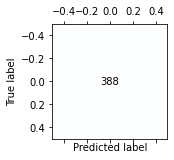

[[388]]
No err
ループ
taketomi_route taketomi_dep 9
Labels counts in y[0 1]: [1912    2]
Labels counts in y_train[0 1]: [1529    2]
Labels counts in y_test[0 1]: [383]
[LightGBM] [Info] Number of positive: 2, number of negative: 1529
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 570
[LightGBM] [Info] Number of data points in the train set: 1531, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001306 -> initscore=-6.639222
[LightGBM] [Info] Start training from score -6.639222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[80]	Train's auc: 1	Test's auc: 1
[100]	Train's auc: 1	Test's auc: 1
1.0


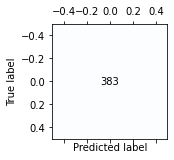

[[383]]
No err
ループ
kurosima_route isigaki_dep 1
Labels counts in y[0 1]: [2447    6]
Labels counts in y_train[0 1]: [1957    5]
Labels counts in y_test[0 1]: [490   1]
[LightGBM] [Info] Number of positive: 5, number of negative: 1957
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 595
[LightGBM] [Info] Number of data points in the train set: 1962, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002548 -> initscore=-5.969730
[LightGBM] [Info] Start training from score -5.969730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.999336	Test's auc: 0.99

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[80]	Train's auc: 0.999336	Test's auc: 0.997959
[100]	Train's auc: 0.999336	Test's auc: 0.997959
0.9979633401221996


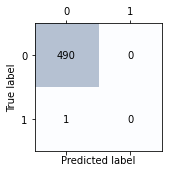

[[490   0]
 [  1   0]]
No err
ループ
kurosima_route isigaki_dep 2
Labels counts in y[0 1]: [2436    6]
Labels counts in y_train[0 1]: [1948    5]
Labels counts in y_test[0 1]: [488   1]
[LightGBM] [Info] Number of positive: 5, number of negative: 1948
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 592
[LightGBM] [Info] Number of data points in the train set: 1953, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002560 -> initscore=-5.965121
[LightGBM] [Info] Start training from score -5.965121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.998768	Test's auc: 1
[100]	Train's auc: 0.998768	Test's auc: 1
1.0


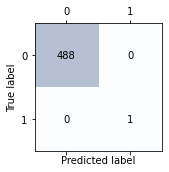

[[488   0]
 [  0   1]]
No err
ループ
kurosima_route isigaki_dep 3
Labels counts in y[0 1]: [2410    6]
Labels counts in y_train[0 1]: [1927    5]
Labels counts in y_test[0 1]: [483   1]
[LightGBM] [Info] Number of positive: 5, number of negative: 1927
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 1932, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002588 -> initscore=-5.954282
[LightGBM] [Info] Start training from score -5.954282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.999273	Test's auc: 1
[40]	Train's auc: 0.999273	Test's auc: 1
[60]	Train's auc: 0.9

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.999273	Test's auc: 1
[100]	Train's auc: 0.999273	Test's auc: 1
0.9958677685950413


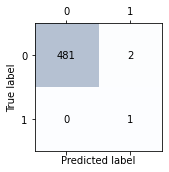

[[481   2]
 [  0   1]]
No err
ループ
kurosima_route isigaki_dep 4
Labels counts in y[0 1]: [2393]
Labels counts in y_train[0 1]: [1914]
Labels counts in y_test[0 1]: [479]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 1914
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 1914, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Light

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


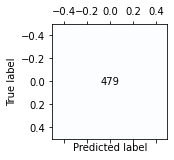

[[479]]
No err
ループ
kurosima_route isigaki_dep 5
Labels counts in y[0 1]: [2362    5]
Labels counts in y_train[0 1]: [1889    4]
Labels counts in y_test[0 1]: [473   1]
[LightGBM] [Info] Number of positive: 4, number of negative: 1889
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 1893, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002113 -> initscore=-6.157509
[LightGBM] [Info] Start training from score -6.157509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[100]	Train's auc: 0.999338	Test's auc: 1
1.0


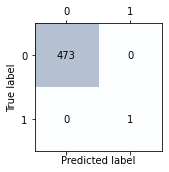

[[473   0]
 [  0   1]]
No err
ループ
kurosima_route isigaki_dep 6
Labels counts in y[0 1]: [2335    6]
Labels counts in y_train[0 1]: [1867    5]
Labels counts in y_test[0 1]: [468   1]
[LightGBM] [Info] Number of positive: 5, number of negative: 1867
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 1872, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002671 -> initscore=-5.922650
[LightGBM] [Info] Start training from score -5.922650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	Train's auc: 0.998875	Test's auc: 1
1.0


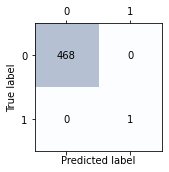

[[468   0]
 [  0   1]]
No err
ループ
kurosima_route isigaki_dep 7
Labels counts in y[0 1]: [2306    6]
Labels counts in y_train[0 1]: [1844    5]
Labels counts in y_test[0 1]: [462   1]
[LightGBM] [Info] Number of positive: 5, number of negative: 1844
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 1849, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002704 -> initscore=-5.910254
[LightGBM] [Info] Start training from score -5.910254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998644	Test's auc: 1
[40]	Train's auc: 0.998644	Test's auc: 1
[60]	Train's auc: 0.9

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.998644	Test's auc: 1
[100]	Train's auc: 0.998644	Test's auc: 1
0.9978401727861771


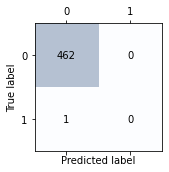

[[462   0]
 [  1   0]]
No err
ループ
kurosima_route isigaki_dep 8
Labels counts in y[0 1]: [2281    5]
Labels counts in y_train[0 1]: [1824    4]
Labels counts in y_test[0 1]: [457   1]
[LightGBM] [Info] Number of positive: 4, number of negative: 1824
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 1828, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002188 -> initscore=-6.122493
[LightGBM] [Info] Start training from score -6.122493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.999657	Test's auc: 0.998906
[40]	Train's auc: 0.999657	Test's auc: 0.998906
[60]	Tr

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	Train's auc: 0.999657	Test's auc: 0.998906
0.9978165938864629


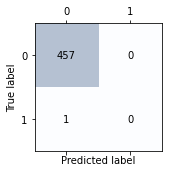

[[457   0]
 [  1   0]]
No err
ループ
kurosima_route isigaki_dep 9
Labels counts in y[0 1]: [2254    6]
Labels counts in y_train[0 1]: [1803    5]
Labels counts in y_test[0 1]: [451   1]
[LightGBM] [Info] Number of positive: 5, number of negative: 1803
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 577
[LightGBM] [Info] Number of data points in the train set: 1808, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002765 -> initscore=-5.887769
[LightGBM] [Info] Start training from score -5.887769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	Train's auc: 0.999445	Test's auc: 0.903548
0.9977876106194691


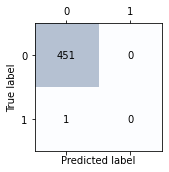

[[451   0]
 [  1   0]]
No err
ループ
kurosima_route kurosima_dep 1
Labels counts in y[0 1]: [2814   10]
Labels counts in y_train[0 1]: [2251    8]
Labels counts in y_test[0 1]: [563   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2251
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 2259, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003541 -> initscore=-5.639688
[LightGBM] [Info] Start training from score -5.639688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.998917	Test's auc: 0.998224
[100]	Train's auc: 0.998917	Test's auc: 0.998224
0.9964601769911504


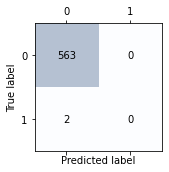

[[563   0]
 [  2   0]]
No err
ループ
kurosima_route kurosima_dep 2
Labels counts in y[0 1]: [2802   10]
Labels counts in y_train[0 1]: [2241    8]
Labels counts in y_test[0 1]: [561   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2241
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 2249, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003557 -> initscore=-5.635236
[LightGBM] [Info] Start training from score -5.635236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998633	Test's auc: 0.996435
[40]	Train's auc: 0.998801	Test's auc: 0.996435
[60]	T

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.999135	Test's auc: 0.996435
[100]	Train's auc: 0.999135	Test's auc: 0.996435
0.9964476021314387


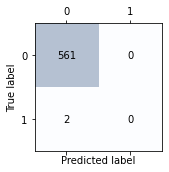

[[561   0]
 [  2   0]]
No err
ループ
kurosima_route kurosima_dep 3
Labels counts in y[0 1]: [2772   10]
Labels counts in y_train[0 1]: [2217    8]
Labels counts in y_test[0 1]: [555   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2217
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003596 -> initscore=-5.624469
[LightGBM] [Info] Start training from score -5.624469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.999295	Test's auc: 0.992342
[40]	Train's auc: 0.999295	Test's auc: 0.992342
[60]	T

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.999295	Test's auc: 0.992342
[100]	Train's auc: 0.999295	Test's auc: 0.992342
0.992818671454219


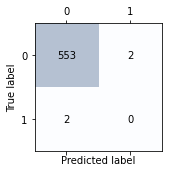

[[553   2]
 [  2   0]]
No err
ループ
kurosima_route kurosima_dep 4
Labels counts in y[0 1]: [2756]
Labels counts in y_train[0 1]: [2204]
Labels counts in y_test[0 1]: [552]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 2204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 2204, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Ligh

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


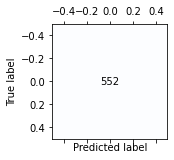

[[552]]
No err
ループ
kurosima_route kurosima_dep 5
Labels counts in y[0 1]: [2718    8]
Labels counts in y_train[0 1]: [2174    6]
Labels counts in y_test[0 1]: [544   2]
[LightGBM] [Info] Number of positive: 6, number of negative: 2174
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 599
[LightGBM] [Info] Number of data points in the train set: 2180, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002752 -> initscore=-5.892565
[LightGBM] [Info] Start training from score -5.892565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[80]	Train's auc: 0.999578	Test's auc: 0.996783
[100]	Train's auc: 0.999578	Test's auc: 0.996783
0.9945054945054945


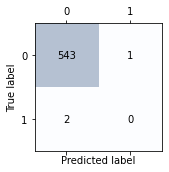

[[543   1]
 [  2   0]]
No err
ループ
kurosima_route kurosima_dep 6
Labels counts in y[0 1]: [2686   10]
Labels counts in y_train[0 1]: [2148    8]
Labels counts in y_test[0 1]: [538   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2148
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 2156, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003711 -> initscore=-5.592851
[LightGBM] [Info] Start training from score -5.592851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.998923	Test's auc: 0.995353
[100]	Train's auc: 0.998923	Test's auc: 0.995353
0.9944444444444445


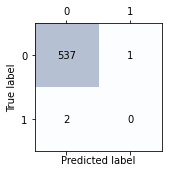

[[537   1]
 [  2   0]]
No err
ループ
kurosima_route kurosima_dep 7
Labels counts in y[0 1]: [2652   10]
Labels counts in y_train[0 1]: [2121    8]
Labels counts in y_test[0 1]: [531   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2121
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 591
[LightGBM] [Info] Number of data points in the train set: 2129, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003758 -> initscore=-5.580201
[LightGBM] [Info] Start training from score -5.580201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.997643	

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	Train's auc: 0.997643	Test's auc: 1
0.9962476547842402


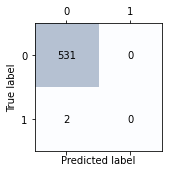

[[531   0]
 [  2   0]]
No err
ループ
kurosima_route kurosima_dep 8
Labels counts in y[0 1]: [2624    8]
Labels counts in y_train[0 1]: [2099    6]
Labels counts in y_test[0 1]: [525   2]
[LightGBM] [Info] Number of positive: 6, number of negative: 2099
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 2105, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002850 -> initscore=-5.857457
[LightGBM] [Info] Start training from score -5.857457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998849	Test's auc: 0.999524
[40]	Train's auc: 0.998849	Test's auc: 0.999524
[60]	T

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.998849	Test's auc: 0.999524
[100]	Train's auc: 0.998849	Test's auc: 0.999524
0.9981024667931688


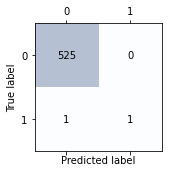

[[525   0]
 [  1   1]]
No err
ループ
kurosima_route kurosima_dep 9
Labels counts in y[0 1]: [2592   10]
Labels counts in y_train[0 1]: [2073    8]
Labels counts in y_test[0 1]: [519   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2073
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 2081, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003844 -> initscore=-5.557311
[LightGBM] [Info] Start training from score -5.557311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.998734	Test's auc: 0.953757
[100]	Train's auc: 0.998734	Test's auc: 0.965318
0.9942418426103646


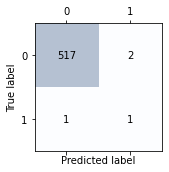

[[517   2]
 [  1   1]]
No err
ループ
kohama_route isigaki_dep 1
Labels counts in y[0 1]: [3350   10]
Labels counts in y_train[0 1]: [2680    8]
Labels counts in y_test[0 1]: [670   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2680
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002976 -> initscore=-5.814131
[LightGBM] [Info] Start training from score -5.814131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.997971	Test's auc: 1
[100]	Train's auc: 0.997971	Test's auc: 1
0.9985119047619048


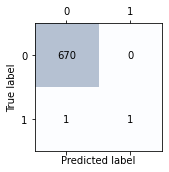

[[670   0]
 [  1   1]]
No err
ループ
kohama_route isigaki_dep 2
Labels counts in y[0 1]: [3337   10]
Labels counts in y_train[0 1]: [2669    8]
Labels counts in y_test[0 1]: [668   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2669
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 2677, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002988 -> initscore=-5.810018
[LightGBM] [Info] Start training from score -5.810018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998267	Test's auc: 0.999626
[40]	Train's auc: 0.998314	Test's auc: 0.999626


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.998314	Test's auc: 0.999626
[80]	Train's auc: 0.998314	Test's auc: 0.999626
[100]	Train's auc: 0.998314	Test's auc: 0.999626
0.9985074626865672


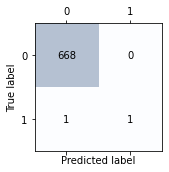

[[668   0]
 [  1   1]]
No err
ループ
kohama_route isigaki_dep 3
Labels counts in y[0 1]: [3300   10]
Labels counts in y_train[0 1]: [2640    8]
Labels counts in y_test[0 1]: [660   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2640
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 627
[LightGBM] [Info] Number of data points in the train set: 2648, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003021 -> initscore=-5.799093
[LightGBM] [Info] Start training from score -5.799093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998793	Test's auc: 0.997348
[40]	Train's auc: 0.998935	Test's auc: 0.997348
[60]	Train's auc: 0.998935	Test's auc: 0.997348


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.998935	Test's auc: 0.997348
[100]	Train's auc: 0.998935	Test's auc: 0.997348
0.9969788519637462


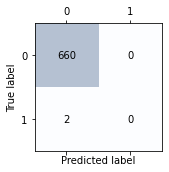

[[660   0]
 [  2   0]]
No err
ループ
kohama_route isigaki_dep 4
Labels counts in y[0 1]: [3277]
Labels counts in y_train[0 1]: [2621]
Labels counts in y_test[0 1]: [656]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 2621
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 2621, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGB

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


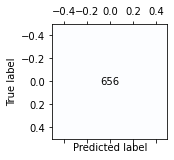

[[656]]
No err
ループ
kohama_route isigaki_dep 5
Labels counts in y[0 1]: [3232    8]
Labels counts in y_train[0 1]: [2586    6]
Labels counts in y_test[0 1]: [646   2]
[LightGBM] [Info] Number of positive: 6, number of negative: 2586
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 2592, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002315 -> initscore=-6.066108
[LightGBM] [Info] Start training from score -6.066108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998485	Test's auc: 0.994969
[40]	Train's auc: 0.998485	Test's auc: 0.994969
[60]	Train's auc: 0.9991

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[100]	Train's auc: 0.99913	Test's auc: 0.998839
0.9969135802469136


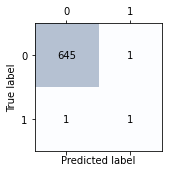

[[645   1]
 [  1   1]]
No err
ループ
kohama_route isigaki_dep 6
Labels counts in y[0 1]: [3193   10]
Labels counts in y_train[0 1]: [2554    8]
Labels counts in y_test[0 1]: [639   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2554
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 2562, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003123 -> initscore=-5.765974
[LightGBM] [Info] Start training from score -5.765974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.998825	Test's auc: 0.997261
[100]	Train's auc: 0.998825	Test's auc: 0.997261
0.9968798751950078


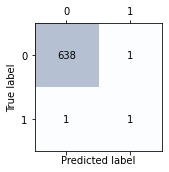

[[638   1]
 [  1   1]]
No err
ループ
kohama_route isigaki_dep 7
Labels counts in y[0 1]: [3153   10]
Labels counts in y_train[0 1]: [2522    8]
Labels counts in y_test[0 1]: [631   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2522
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 2530, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003162 -> initscore=-5.753366
[LightGBM] [Info] Start training from score -5.753366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998092	Test's auc: 0.999604
[40]	Train's auc: 0.998092	Test's auc: 0.999604
[60]	Trai

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	Train's auc: 0.99829	Test's auc: 0.999604
0.9984202211690363


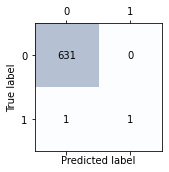

[[631   0]
 [  1   1]]
No err
ループ
kohama_route isigaki_dep 8
Labels counts in y[0 1]: [3118    8]
Labels counts in y_train[0 1]: [2494    6]
Labels counts in y_test[0 1]: [624   2]
[LightGBM] [Info] Number of positive: 6, number of negative: 2494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002400 -> initscore=-6.029884
[LightGBM] [Info] Start training from score -6.029884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.999198	Test's auc: 0.999199
[40]	Train's auc: 0.999198	Test's auc: 0.999199
[60]	Train's auc: 0.999198	Test's auc: 0.999199
[80]	Train's auc: 0.999198	Test's au

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	Train's auc: 0.999198	Test's auc: 0.999199
0.9968051118210862


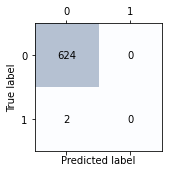

[[624   0]
 [  2   0]]
No err
ループ
kohama_route isigaki_dep 9
Labels counts in y[0 1]: [3079   10]
Labels counts in y_train[0 1]: [2463    8]
Labels counts in y_test[0 1]: [616   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2463
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 2471, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003238 -> initscore=-5.729694
[LightGBM] [Info] Start training from score -5.729694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998452	Test's auc: 0.993101
[40]	Train's auc: 0.998554	Test's auc: 0.995536
[60]	Trai

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	Train's auc: 0.998604	Test's auc: 0.996347
0.9967637540453075


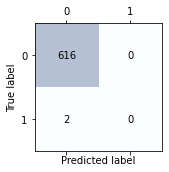

[[616   0]
 [  2   0]]
No err
ループ
kohama_route kohama_dep 1
Labels counts in y[0 1]: [3954   10]
Labels counts in y_train[0 1]: [3163    8]
Labels counts in y_test[0 1]: [791   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 3163
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 654
[LightGBM] [Info] Number of data points in the train set: 3171, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002523 -> initscore=-5.979835
[LightGBM] [Info] Start training from score -5.979835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998202	Test's auc: 0.9

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.998439	Test's auc: 0.999368
[100]	Train's auc: 0.998439	Test's auc: 0.999368
0.9987389659520807


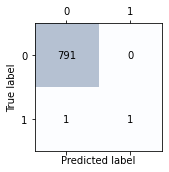

[[791   0]
 [  1   1]]
No err
ループ
kohama_route kohama_dep 2
Labels counts in y[0 1]: [3940   10]
Labels counts in y_train[0 1]: [3152    8]
Labels counts in y_test[0 1]: [788   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 3152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 3160, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002532 -> initscore=-5.976351
[LightGBM] [Info] Start training from score -5.976351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998711	Test's auc: 0.998731
[40]	Train's auc: 0.998711	Test's auc: 0.998731
[60]	Train

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	Train's auc: 0.998711	Test's auc: 0.998731
0.9974683544303797


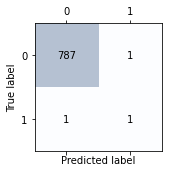

[[787   1]
 [  1   1]]
No err
ループ
kohama_route kohama_dep 3
Labels counts in y[0 1]: [3896   10]
Labels counts in y_train[0 1]: [3116    8]
Labels counts in y_test[0 1]: [780   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 3116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 3124, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002561 -> initscore=-5.964864
[LightGBM] [Info] Start training from score -5.964864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998616	Test's auc: 0.996474
[40]	Train's auc: 0.999499	Test's auc: 0.994551
[60]	Train's auc: 0.999499	Test's auc: 0.994551


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.999499	Test's auc: 0.994551
[100]	Train's auc: 0.999499	Test's auc: 0.994551
0.9948849104859335


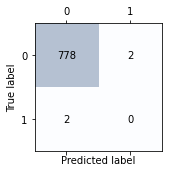

[[778   2]
 [  2   0]]
No err
ループ
kohama_route kohama_dep 4
Labels counts in y[0 1]: [3866]
Labels counts in y_train[0 1]: [3092]
Labels counts in y_test[0 1]: [774]
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 3092
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


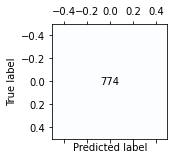

[[774]]
No err
ループ
kohama_route kohama_dep 5
Labels counts in y[0 1]: [3814    8]
Labels counts in y_train[0 1]: [3051    6]
Labels counts in y_test[0 1]: [763   2]
[LightGBM] [Info] Number of positive: 6, number of negative: 3051
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 3057, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001963 -> initscore=-6.231465
[LightGBM] [Info] Start training from score -6.231465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998662	Test's auc: 0.99443
[40]	Train's auc: 0.998662	Test's auc: 0.99443
[60]	Train's auc: 0.999263	Test's auc: 0.998362


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1493: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/

[80]	Train's auc: 0.999263	Test's auc: 0.998362
[100]	Train's auc: 0.999263	Test's auc: 0.998362
0.9973856209150327


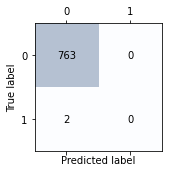

[[763   0]
 [  2   0]]
No err
ループ
kohama_route kohama_dep 6
Labels counts in y[0 1]: [3768   10]
Labels counts in y_train[0 1]: [3014    8]
Labels counts in y_test[0 1]: [754   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 3014
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 647
[LightGBM] [Info] Number of data points in the train set: 3022, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002647 -> initscore=-5.931582
[LightGBM] [Info] Start training from score -5.931582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.998362	Test

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	Train's auc: 0.99915	Test's auc: 0.995358
0.996031746031746


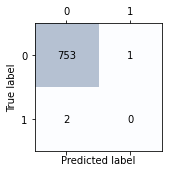

[[753   1]
 [  2   0]]
No err
ループ
kohama_route kohama_dep 7
Labels counts in y[0 1]: [3722   10]
Labels counts in y_train[0 1]: [2977    8]
Labels counts in y_test[0 1]: [745   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2977
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 2985, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002680 -> initscore=-5.919230
[LightGBM] [Info] Start training from score -5.919230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.99916	Test's auc: 0.241611
[40]	Train's auc: 0.99916	Test's auc: 0.791946
[60]	Train's

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.99916	Test's auc: 0.778523
[100]	Train's auc: 0.99916	Test's auc: 0.775839
0.9973226238286479


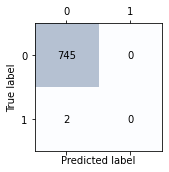

[[745   0]
 [  2   0]]
No err
ループ
kohama_route kohama_dep 8
Labels counts in y[0 1]: [3680    8]
Labels counts in y_train[0 1]: [2944    6]
Labels counts in y_test[0 1]: [736   2]
[LightGBM] [Info] Number of positive: 6, number of negative: 2944
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 2950, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002034 -> initscore=-6.195765
[LightGBM] [Info] Start training from score -6.195765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	Train's auc: 0.999179	Test's auc: 0.99966
[40]	Train's auc: 0.999179	Test's auc: 0.99966
[60]	Train's auc: 0.999179	Test's auc: 0.99966
[80]	Train's auc: 0.999066	Test's auc: 0

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	Train's auc: 0.999066	Test's auc: 0.99966
0.9986449864498645


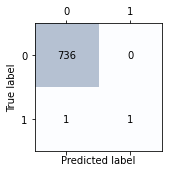

[[736   0]
 [  1   1]]
No err
ループ
kohama_route kohama_dep 9
Labels counts in y[0 1]: [3634   10]
Labels counts in y_train[0 1]: [2907    8]
Labels counts in y_test[0 1]: [727   2]
[LightGBM] [Info] Number of positive: 8, number of negative: 2907
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 2915, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.002744 -> initscore=-5.895435
[LightGBM] [Info] Start training from score -5.895435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.998603	Test's auc: 0.996905
[100]	Train's auc: 0.998603	Test's auc: 0.996905
0.9972565157750343


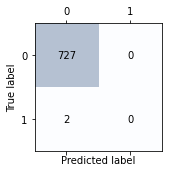

[[727   0]
 [  2   0]]
No err
ループ
iriomote_uehara_route isigaki_dep 1
Labels counts in y[0 1]: [4294  340]
Labels counts in y_train[0 1]: [3435  272]
Labels counts in y_test[0 1]: [859  68]
[LightGBM] [Info] Number of positive: 272, number of negative: 3435
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 3707, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073375 -> initscore=-2.535970
[LightGBM] [Info] Start training from score -2.535970
[20]	Train's auc: 0.921881	Test's auc: 0.793964
[40]	Train's auc: 0.935767	Test's auc: 0.796138


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.938821	Test's auc: 0.794255
[80]	Train's auc: 0.940122	Test's auc: 0.793142
[100]	Train's auc: 0.941141	Test's auc: 0.794255
0.9234088457389428


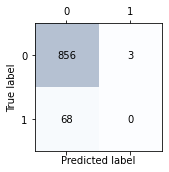

[[856   3]
 [ 68   0]]
No err
ループ
iriomote_uehara_route isigaki_dep 2
Labels counts in y[0 1]: [4283  336]
Labels counts in y_train[0 1]: [3426  269]
Labels counts in y_test[0 1]: [857  67]
[LightGBM] [Info] Number of positive: 269, number of negative: 3426
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 677
[LightGBM] [Info] Number of data points in the train set: 3695, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072801 -> initscore=-2.544437
[LightGBM] [Info] Start training from score -2.544437
[20]	Train's auc: 0.926615	Test's auc: 0.762579
[40]	Train's auc: 0.936855	Test's auc: 0.769858
[60]	Train's auc: 0.941468	Test's auc: 0.771008


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.942905	Test's auc: 0.768587
[100]	Train's auc: 0.944235	Test's auc: 0.769545
0.9199134199134199


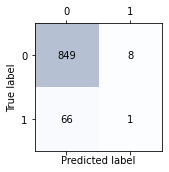

[[849   8]
 [ 66   1]]
No err
ループ
iriomote_uehara_route isigaki_dep 3
Labels counts in y[0 1]: [4231  337]
Labels counts in y_train[0 1]: [3384  270]
Labels counts in y_test[0 1]: [847  67]
[LightGBM] [Info] Number of positive: 270, number of negative: 3384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 3654, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073892 -> initscore=-2.528392
[LightGBM] [Info] Start training from score -2.528392
[20]	Train's auc: 0.918307	Test's auc: 0.745035
[40]	Train's auc: 0.93083	Test's auc: 0.750551
[60]	Train's auc: 0.934854	Test's auc: 0.753


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.937162	Test's auc: 0.753987
[100]	Train's auc: 0.938623	Test's auc: 0.756084
0.9223194748358862


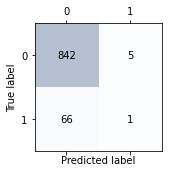

[[842   5]
 [ 66   1]]
No err
ループ
iriomote_uehara_route isigaki_dep 4
Labels counts in y[0 1]: [4206  315]
Labels counts in y_train[0 1]: [3364  252]
Labels counts in y_test[0 1]: [842  63]
[LightGBM] [Info] Number of positive: 252, number of negative: 3364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 3616, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069690 -> initscore=-2.591457
[LightGBM] [Info] Start training from score -2.591457
[20]	Train's auc: 0.924547	Test's auc: 0.731582
[40]	Train's auc: 0.933787	Test's auc: 0.737652
[60]	Train's auc: 0.937784	Test's auc: 0.729942


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.939434	Test's auc: 0.72866
[100]	Train's auc: 0.94107	Test's auc: 0.724532
0.9248618784530387


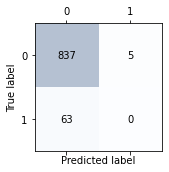

[[837   5]
 [ 63   0]]
No err
ループ
iriomote_uehara_route isigaki_dep 5
Labels counts in y[0 1]: [4149  321]
Labels counts in y_train[0 1]: [3319  257]
Labels counts in y_test[0 1]: [830  64]
[LightGBM] [Info] Number of positive: 257, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 3576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071868 -> initscore=-2.558343
[LightGBM] [Info] Start training from score -2.558343
[20]	Train's auc: 0.919313	Test's auc: 0.768552
[40]	Train's auc: 0.931243	Test's auc: 0.76635
[60]	Train's auc: 0.936482	Test's auc: 0.766143


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.937901	Test's auc: 0.763451
[100]	Train's auc: 0.939396	Test's auc: 0.762255
0.9250559284116331


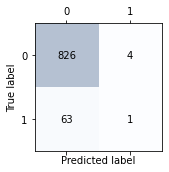

[[826   4]
 [ 63   1]]
No err
ループ
iriomote_uehara_route isigaki_dep 6
Labels counts in y[0 1]: [4104  315]
Labels counts in y_train[0 1]: [3283  252]
Labels counts in y_test[0 1]: [821  63]
[LightGBM] [Info] Number of positive: 252, number of negative: 3283
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 3535, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071287 -> initscore=-2.567084
[LightGBM] [Info] Start training from score -2.567084
[20]	Train's auc: 0.923395	Test's auc: 0.769706
[40]	Train's auc: 0.935071	Test's auc: 0.77393
[60]	Train's auc: 0.939157	Test's auc: 0.768904


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.94167	Test's auc: 0.770083
[100]	Train's auc: 0.942332	Test's auc: 0.76873
0.9264705882352942


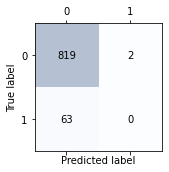

[[819   2]
 [ 63   0]]
No err
ループ
iriomote_uehara_route isigaki_dep 7
Labels counts in y[0 1]: [4050  317]
Labels counts in y_train[0 1]: [3239  254]
Labels counts in y_test[0 1]: [811  63]
[LightGBM] [Info] Number of positive: 254, number of negative: 3239
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 3493, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072717 -> initscore=-2.545686
[LightGBM] [Info] Start training from score -2.545686
[20]	Train's auc: 0.921651	Test's auc: 0.761738
[40]	Train's auc: 0.931747	Test's auc: 0.764733
[60]	Train's auc: 0.935208	Test's auc: 0.767825


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.936812	Test's auc: 0.773403
[100]	Train's auc: 0.938537	Test's auc: 0.768491
0.9279176201372997


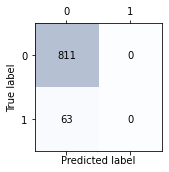

[[811   0]
 [ 63   0]]
No err
ループ
iriomote_uehara_route isigaki_dep 8
Labels counts in y[0 1]: [3989  327]
Labels counts in y_train[0 1]: [3190  262]
Labels counts in y_test[0 1]: [799  65]
[LightGBM] [Info] Number of positive: 262, number of negative: 3190
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 3452, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.075898 -> initscore=-2.499432
[LightGBM] [Info] Start training from score -2.499432
[20]	Train's auc: 0.915758	Test's auc: 0.769539
[40]	Train's auc: 0.9287	Test's auc: 0.777876


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.933784	Test's auc: 0.774276
[80]	Train's auc: 0.936187	Test's auc: 0.777761
[100]	Train's auc: 0.937747	Test's auc: 0.775161
0.9247685185185185


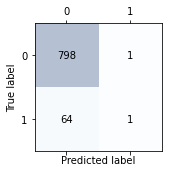

[[798   1]
 [ 64   1]]
No err
ループ
iriomote_uehara_route isigaki_dep 9
Labels counts in y[0 1]: [3951  314]
Labels counts in y_train[0 1]: [3161  251]
Labels counts in y_test[0 1]: [790  63]
[LightGBM] [Info] Number of positive: 251, number of negative: 3161
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 673
[LightGBM] [Info] Number of data points in the train set: 3412, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.073564 -> initscore=-2.533191
[LightGBM] [Info] Start training from score -2.533191
[20]	Train's auc: 0.916342	Test's auc: 0.788387
[40]	Train's auc: 0.929308	Test's auc: 0.800985


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.934298	Test's auc: 0.802984
[80]	Train's auc: 0.936011	Test's auc: 0.798563
[100]	Train's auc: 0.937569	Test's auc: 0.799307
0.9249706916764361


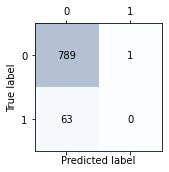

[[789   1]
 [ 63   0]]
No err
ループ
iriomote_uehara_route uehara_dep 1
Labels counts in y[0 1]: [4631  671]
Labels counts in y_train[0 1]: [3704  537]
Labels counts in y_test[0 1]: [927 134]
[LightGBM] [Info] Number of positive: 537, number of negative: 3704
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 4241, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126621 -> initscore=-1.931171
[LightGBM] [Info] Start training from score -1.931171
[20]	Train's auc: 0.919756	Test's auc: 0.857597
[40]	Train's auc: 0.927457	Test's auc: 0.863224
[60]	Train's auc: 0.931224	Test's auc: 0.864593


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.932415	Test's auc: 0.866501
[100]	Train's auc: 0.933471	Test's auc: 0.86601
0.8708765315739868


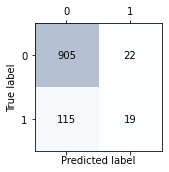

[[905  22]
 [115  19]]
No err
ループ
iriomote_uehara_route uehara_dep 2
Labels counts in y[0 1]: [4625  661]
Labels counts in y_train[0 1]: [3699  529]
Labels counts in y_test[0 1]: [926 132]
[LightGBM] [Info] Number of positive: 529, number of negative: 3699
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 4228, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125118 -> initscore=-1.944829
[LightGBM] [Info] Start training from score -1.944829
[20]	Train's auc: 0.918272	Test's auc: 0.834998
[40]	Train's auc: 0.929585	Test's auc: 0.848055
[60]	Train's auc: 0.934095	Test's auc: 0.852637


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.936262	Test's auc: 0.856016
[100]	Train's auc: 0.937637	Test's auc: 0.858208
0.8686200378071833


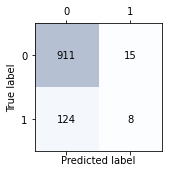

[[911  15]
 [124   8]]
No err
ループ
iriomote_uehara_route uehara_dep 3
Labels counts in y[0 1]: [4564  664]
Labels counts in y_train[0 1]: [3651  531]
Labels counts in y_test[0 1]: [913 133]
[LightGBM] [Info] Number of positive: 531, number of negative: 3651
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 4182, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126973 -> initscore=-1.927994
[LightGBM] [Info] Start training from score -1.927994
[20]	Train's auc: 0.914964	Test's auc: 0.853709
[40]	Train's auc: 0.92503	Test's auc: 0.862916
[60]	Train's auc: 0.929992	Test's auc: 0.871019


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.931245	Test's auc: 0.871151
[100]	Train's auc: 0.932267	Test's auc: 0.875079
0.8747609942638623


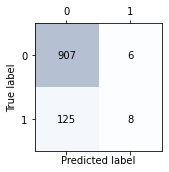

[[907   6]
 [125   8]]
No err
ループ
iriomote_uehara_route uehara_dep 4
Labels counts in y[0 1]: [4544  631]
Labels counts in y_train[0 1]: [3635  505]
Labels counts in y_test[0 1]: [909 126]
[LightGBM] [Info] Number of positive: 505, number of negative: 3635
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 4140, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121981 -> initscore=-1.973806
[LightGBM] [Info] Start training from score -1.973806
[20]	Train's auc: 0.919709	Test's auc: 0.851974


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	Train's auc: 0.929397	Test's auc: 0.867389
[60]	Train's auc: 0.933737	Test's auc: 0.876482
[80]	Train's auc: 0.935543	Test's auc: 0.877111
[100]	Train's auc: 0.935997	Test's auc: 0.87361
0.8792270531400966


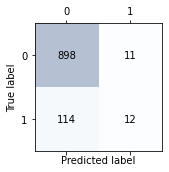

[[898  11]
 [114  12]]
No err
ループ
iriomote_uehara_route uehara_dep 5
Labels counts in y[0 1]: [4479  638]
Labels counts in y_train[0 1]: [3583  510]
Labels counts in y_test[0 1]: [896 128]
[LightGBM] [Info] Number of positive: 510, number of negative: 3583
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 4093, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124603 -> initscore=-1.949545
[LightGBM] [Info] Start training from score -1.949545
[20]	Train's auc: 0.910229	Test's auc: 0.824663


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	Train's auc: 0.921647	Test's auc: 0.836884
[60]	Train's auc: 0.927051	Test's auc: 0.842316
[80]	Train's auc: 0.929439	Test's auc: 0.847565
[100]	Train's auc: 0.930304	Test's auc: 0.848376
0.873046875


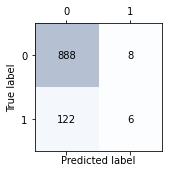

[[888   8]
 [122   6]]
No err
ループ
iriomote_uehara_route uehara_dep 6
Labels counts in y[0 1]: [4436  623]
Labels counts in y_train[0 1]: [3549  498]
Labels counts in y_test[0 1]: [887 125]
[LightGBM] [Info] Number of positive: 498, number of negative: 3549
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 4047, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123054 -> initscore=-1.963821
[LightGBM] [Info] Start training from score -1.963821
[20]	Train's auc: 0.921674	Test's auc: 0.818737
[40]	Train's auc: 0.931236	Test's auc: 0.829912
[60]	Train's auc: 0.934727	Test's auc: 0.832068


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.9368	Test's auc: 0.834521
[100]	Train's auc: 0.937349	Test's auc: 0.836469
0.8646245059288538


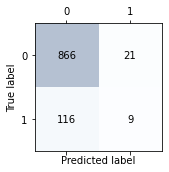

[[866  21]
 [116   9]]
No err
ループ
iriomote_uehara_route uehara_dep 7
Labels counts in y[0 1]: [4376  624]
Labels counts in y_train[0 1]: [3501  499]
Labels counts in y_test[0 1]: [875 125]
[LightGBM] [Info] Number of positive: 499, number of negative: 3501
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124750 -> initscore=-1.948198
[LightGBM] [Info] Start training from score -1.948198
[20]	Train's auc: 0.913505	Test's auc: 0.836576
[40]	Train's auc: 0.922459	Test's auc: 0.847218


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.926316	Test's auc: 0.855374
[80]	Train's auc: 0.928201	Test's auc: 0.855886
[100]	Train's auc: 0.929238	Test's auc: 0.858437
0.87


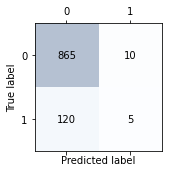

[[865  10]
 [120   5]]
No err
ループ
iriomote_uehara_route uehara_dep 8
Labels counts in y[0 1]: [4298  644]
Labels counts in y_train[0 1]: [3438  515]
Labels counts in y_test[0 1]: [860 129]
[LightGBM] [Info] Number of positive: 515, number of negative: 3438
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130281 -> initscore=-1.898478
[LightGBM] [Info] Start training from score -1.898478
[20]	Train's auc: 0.905761	Test's auc: 0.822805
[40]	Train's auc: 0.919377	Test's auc: 0.842361
[60]	Train's auc: 0.925091	Test's auc: 0.849175


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.928426	Test's auc: 0.851879
[100]	Train's auc: 0.929521	Test's auc: 0.853574
0.8645096056622852


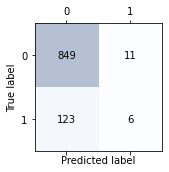

[[849  11]
 [123   6]]
No err
ループ
iriomote_uehara_route uehara_dep 9
Labels counts in y[0 1]: [4268  616]
Labels counts in y_train[0 1]: [3414  493]
Labels counts in y_test[0 1]: [854 123]
[LightGBM] [Info] Number of positive: 493, number of negative: 3414
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 3907, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126184 -> initscore=-1.935131
[LightGBM] [Info] Start training from score -1.935131
[20]	Train's auc: 0.916049	Test's auc: 0.817559
[40]	Train's auc: 0.928142	Test's auc: 0.828102
[60]	Train's auc: 0.932553	Test's auc: 0.828645


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.934327	Test's auc: 0.829083
[100]	Train's auc: 0.935428	Test's auc: 0.830368
0.8730808597748209


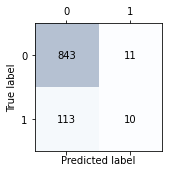

[[843  11]
 [113  10]]
No err
ループ
hatoma_route isigaki_dep 1
Labels counts in y[0 1]: [4728  764]
Labels counts in y_train[0 1]: [3782  611]
Labels counts in y_test[0 1]: [946 153]
[LightGBM] [Info] Number of positive: 611, number of negative: 3782
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 4393, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139085 -> initscore=-1.822911
[LightGBM] [Info] Start training from score -1.822911
[20]	Train's auc: 0.92211	Test's auc: 0.854589
[40]	Train's auc: 0.930849	Test's auc: 0.86546
[60]	Train's auc: 0.934092	Test's auc: 0.872093


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.935544	Test's auc: 0.876204
[100]	Train's auc: 0.936646	Test's auc: 0.87628
0.8662420382165605


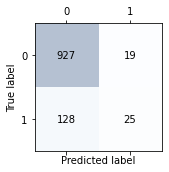

[[927  19]
 [128  25]]
No err
ループ
hatoma_route isigaki_dep 2
Labels counts in y[0 1]: [4721  755]
Labels counts in y_train[0 1]: [3776  604]
Labels counts in y_test[0 1]: [945 151]
[LightGBM] [Info] Number of positive: 604, number of negative: 3776
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 4380, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.137900 -> initscore=-1.832846
[LightGBM] [Info] Start training from score -1.832846
[20]	Train's auc: 0.922902	Test's auc: 0.842717
[40]	Train's auc: 0.932615	Test's auc: 0.849837
[60]	Train's auc: 0.937166	Test's auc: 0.855149


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.938743	Test's auc: 0.856516
[100]	Train's auc: 0.940155	Test's auc: 0.860195
0.8558394160583942


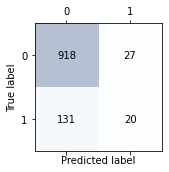

[[918  27]
 [131  20]]
No err
ループ
hatoma_route isigaki_dep 3
Labels counts in y[0 1]: [4659  757]
Labels counts in y_train[0 1]: [3727  605]
Labels counts in y_test[0 1]: [932 152]
[LightGBM] [Info] Number of positive: 605, number of negative: 3727
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 4332, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139658 -> initscore=-1.818130
[LightGBM] [Info] Start training from score -1.818130
[20]	Train's auc: 0.91521	Test's auc: 0.867196
[40]	Train's auc: 0.926066	Test's auc: 0.876684
[60]	Train's auc: 0.931614	Test's auc: 0.882825


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.933685	Test's auc: 0.88375
[100]	Train's auc: 0.934212	Test's auc: 0.883573
0.8616236162361623


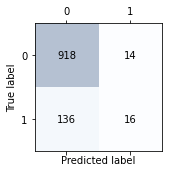

[[918  14]
 [136  16]]
No err
ループ
hatoma_route isigaki_dep 4
Labels counts in y[0 1]: [4641  720]
Labels counts in y_train[0 1]: [3712  576]
Labels counts in y_test[0 1]: [929 144]
[LightGBM] [Info] Number of positive: 576, number of negative: 3712
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 4288, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.134328 -> initscore=-1.863218
[LightGBM] [Info] Start training from score -1.863218
[20]	Train's auc: 0.923394	Test's auc: 0.85478
[40]	Train's auc: 0.934214	Test's auc: 0.867102
[60]	Train's auc: 0.937031	Test's auc: 0.86847


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.938572	Test's auc: 0.867289
[100]	Train's auc: 0.939501	Test's auc: 0.868964
0.8611369990680335


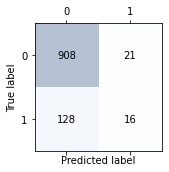

[[908  21]
 [128  16]]
No err
ループ
hatoma_route isigaki_dep 5
Labels counts in y[0 1]: [4575  726]
Labels counts in y_train[0 1]: [3659  581]
Labels counts in y_test[0 1]: [916 145]
[LightGBM] [Info] Number of positive: 581, number of negative: 3659
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 4240, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.137028 -> initscore=-1.840194
[LightGBM] [Info] Start training from score -1.840194
[20]	Train's auc: 0.916351	Test's auc: 0.846808
[40]	Train's auc: 0.927015	Test's auc: 0.860996
[60]	Train's auc: 0.931395	Test's auc: 0.866477


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.933499	Test's auc: 0.869263
[100]	Train's auc: 0.93501	Test's auc: 0.872681
0.8633364750235627


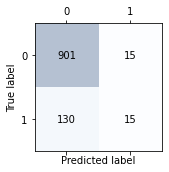

[[901  15]
 [130  15]]
No err
ループ
hatoma_route isigaki_dep 6
Labels counts in y[0 1]: [4531  710]
Labels counts in y_train[0 1]: [3624  568]
Labels counts in y_test[0 1]: [907 142]
[LightGBM] [Info] Number of positive: 568, number of negative: 3624
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 4192, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135496 -> initscore=-1.853212
[LightGBM] [Info] Start training from score -1.853212
[20]	Train's auc: 0.922341	Test's auc: 0.856267
[40]	Train's auc: 0.932625	Test's auc: 0.869023
[60]	Train's auc: 0.935691	Test's auc: 0.869505


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.936977	Test's auc: 0.870739
[100]	Train's auc: 0.938236	Test's auc: 0.872284
0.8674928503336511


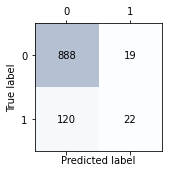

[[888  19]
 [120  22]]
No err
ループ
hatoma_route isigaki_dep 7
Labels counts in y[0 1]: [4470  711]
Labels counts in y_train[0 1]: [3575  569]
Labels counts in y_test[0 1]: [895 142]
[LightGBM] [Info] Number of positive: 569, number of negative: 3575
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 4144, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.137307 -> initscore=-1.837840
[LightGBM] [Info] Start training from score -1.837840
[20]	Train's auc: 0.916847	Test's auc: 0.828031
[40]	Train's auc: 0.92685	Test's auc: 0.83553
[60]	Train's auc: 0.931211	Test's auc: 0.840353


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.933606	Test's auc: 0.842116
[100]	Train's auc: 0.935274	Test's auc: 0.841266
0.8563162970106075


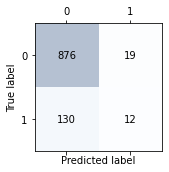

[[876  19]
 [130  12]]
No err
ループ
hatoma_route isigaki_dep 8
Labels counts in y[0 1]: [4386  735]
Labels counts in y_train[0 1]: [3508  588]
Labels counts in y_test[0 1]: [878 147]
[LightGBM] [Info] Number of positive: 588, number of negative: 3508
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 682
[LightGBM] [Info] Number of data points in the train set: 4096, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143555 -> initscore=-1.786074
[LightGBM] [Info] Start training from score -1.786074
[20]	Train's auc: 0.912242	Test's auc: 0.824958
[40]	Train's auc: 0.922056	Test's auc: 0.838257
[60]	Train's auc: 0.926645	Test's auc: 0.842925


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.929565	Test's auc: 0.847404
[100]	Train's auc: 0.930817	Test's auc: 0.84955
0.8478048780487805


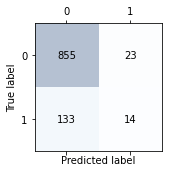

[[855  23]
 [133  14]]
No err
ループ
hatoma_route isigaki_dep 9
Labels counts in y[0 1]: [4360  701]
Labels counts in y_train[0 1]: [3487  561]
Labels counts in y_test[0 1]: [873 140]
[LightGBM] [Info] Number of positive: 561, number of negative: 3487
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 4048, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.138587 -> initscore=-1.827076
[LightGBM] [Info] Start training from score -1.827076
[20]	Train's auc: 0.912548	Test's auc: 0.855584
[40]	Train's auc: 0.926851	Test's auc: 0.868238
[60]	Train's auc: 0.930643	Test's auc: 0.870537


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.932334	Test's auc: 0.871969
[100]	Train's auc: 0.93282	Test's auc: 0.872574
0.8657453109575518


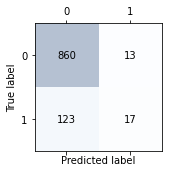

[[860  13]
 [123  17]]
No err
ループ
hatoma_route hatoma_dep 1
Labels counts in y[0 1]: [4821  857]
Labels counts in y_train[0 1]: [3856  686]
Labels counts in y_test[0 1]: [965 171]
[LightGBM] [Info] Number of positive: 686, number of negative: 3856
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 4542, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151035 -> initscore=-1.726508
[LightGBM] [Info] Start training from score -1.726508
[20]	Train's auc: 0.918199	Test's auc: 0.879399
[40]	Train's auc: 0.926029	Test's auc: 0.885174
[60]	Train's auc: 0.930216	Test's auc: 0.889368


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.932454	Test's auc: 0.890283
[100]	Train's auc: 0.933809	Test's auc: 0.891677
0.8591549295774648


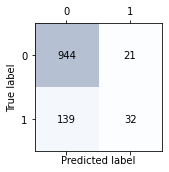

[[944  21]
 [139  32]]
No err
ループ
hatoma_route hatoma_dep 2
Labels counts in y[0 1]: [4815  847]
Labels counts in y_train[0 1]: [3851  678]
Labels counts in y_test[0 1]: [964 169]
[LightGBM] [Info] Number of positive: 678, number of negative: 3851
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 4529, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149702 -> initscore=-1.736941
[LightGBM] [Info] Start training from score -1.736941
[20]	Train's auc: 0.919833	Test's auc: 0.836557
[40]	Train's auc: 0.930607	Test's auc: 0.853173
[60]	Train's auc: 0.935346	Test's auc: 0.856751


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.937014	Test's auc: 0.857531
[100]	Train's auc: 0.938381	Test's auc: 0.858366
0.853486319505737


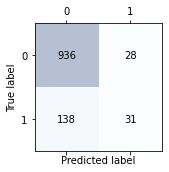

[[936  28]
 [138  31]]
No err
ループ
hatoma_route hatoma_dep 3
Labels counts in y[0 1]: [4749  851]
Labels counts in y_train[0 1]: [3799  681]
Labels counts in y_test[0 1]: [950 170]
[LightGBM] [Info] Number of positive: 681, number of negative: 3799
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 4480, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.152009 -> initscore=-1.718931
[LightGBM] [Info] Start training from score -1.718931
[20]	Train's auc: 0.917787	Test's auc: 0.850638
[40]	Train's auc: 0.929299	Test's auc: 0.862471


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.934542	Test's auc: 0.87057
[80]	Train's auc: 0.936228	Test's auc: 0.874502
[100]	Train's auc: 0.937345	Test's auc: 0.874885
0.8526785714285714


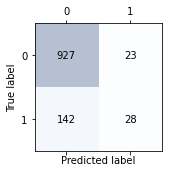

[[927  23]
 [142  28]]
No err
ループ
hatoma_route hatoma_dep 4
Labels counts in y[0 1]: [4733  810]
Labels counts in y_train[0 1]: [3786  648]
Labels counts in y_test[0 1]: [947 162]
[LightGBM] [Info] Number of positive: 648, number of negative: 3786
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 4434, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146143 -> initscore=-1.765175
[LightGBM] [Info] Start training from score -1.765175
[20]	Train's auc: 0.92198	Test's auc: 0.846262
[40]	Train's auc: 0.930302	Test's auc: 0.861219
[60]	Train's auc: 0.934614	Test's auc: 0.867998


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.936818	Test's auc: 0.87097
[100]	Train's auc: 0.93771	Test's auc: 0.872939
0.8503155996393147


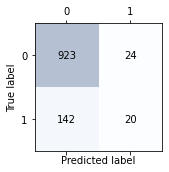

[[923  24]
 [142  20]]
No err
ループ
hatoma_route hatoma_dep 5
Labels counts in y[0 1]: [4665  816]
Labels counts in y_train[0 1]: [3731  653]
Labels counts in y_test[0 1]: [934 163]
[LightGBM] [Info] Number of positive: 653, number of negative: 3731
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 4384, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148951 -> initscore=-1.742854
[LightGBM] [Info] Start training from score -1.742854
[20]	Train's auc: 0.917131	Test's auc: 0.872706
[40]	Train's auc: 0.9275	Test's auc: 0.885537
[60]	Train's auc: 0.932503	Test's auc: 0.888185


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.934437	Test's auc: 0.891692
[100]	Train's auc: 0.935568	Test's auc: 0.891751
0.8632634457611669


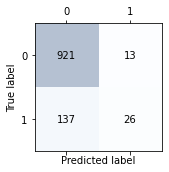

[[921  13]
 [137  26]]
No err
ループ
hatoma_route hatoma_dep 6
Labels counts in y[0 1]: [4622  797]
Labels counts in y_train[0 1]: [3697  638]
Labels counts in y_test[0 1]: [925 159]
[LightGBM] [Info] Number of positive: 638, number of negative: 3697
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 679
[LightGBM] [Info] Number of data points in the train set: 4335, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147174 -> initscore=-1.756939
[LightGBM] [Info] Start training from score -1.756939
[20]	Train's auc: 0.924474	Test's auc: 0.866575
[40]	Train's auc: 0.932166	Test's auc: 0.880187


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.93531	Test's auc: 0.88377
[80]	Train's auc: 0.937127	Test's auc: 0.884525
[100]	Train's auc: 0.938118	Test's auc: 0.884926
0.8514760147601476


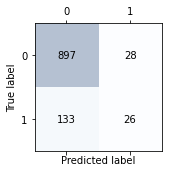

[[897  28]
 [133  26]]
No err
ループ
hatoma_route hatoma_dep 7
Labels counts in y[0 1]: [4561  797]
Labels counts in y_train[0 1]: [3648  638]
Labels counts in y_test[0 1]: [913 159]
[LightGBM] [Info] Number of positive: 638, number of negative: 3648
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 680
[LightGBM] [Info] Number of data points in the train set: 4286, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148857 -> initscore=-1.743596
[LightGBM] [Info] Start training from score -1.743596
[20]	Train's auc: 0.91852	Test's auc: 0.843928
[40]	Train's auc: 0.926598	Test's auc: 0.852442
[60]	Train's auc: 0.931547	Test's auc: 0.857464


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.933312	Test's auc: 0.861404
[100]	Train's auc: 0.935428	Test's auc: 0.863843
0.8535447761194029


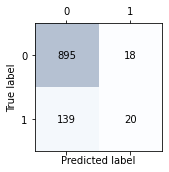

[[895  18]
 [139  20]]
No err
ループ
hatoma_route hatoma_dep 8
Labels counts in y[0 1]: [4474  822]
Labels counts in y_train[0 1]: [3579  657]
Labels counts in y_test[0 1]: [895 165]
[LightGBM] [Info] Number of positive: 657, number of negative: 3579
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 4236, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.155099 -> initscore=-1.695155
[LightGBM] [Info] Start training from score -1.695155
[20]	Train's auc: 0.910046	Test's auc: 0.857958
[40]	Train's auc: 0.92168	Test's auc: 0.865319
[60]	Train's auc: 0.927125	Test's auc: 0.872741


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.929554	Test's auc: 0.874779
[100]	Train's auc: 0.930274	Test's auc: 0.876039
0.8490566037735849


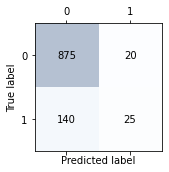

[[875  20]
 [140  25]]
No err
ループ
hatoma_route hatoma_dep 9
Labels counts in y[0 1]: [4449  785]
Labels counts in y_train[0 1]: [3559  628]
Labels counts in y_test[0 1]: [890 157]
[LightGBM] [Info] Number of positive: 628, number of negative: 3559
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 4187, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149988 -> initscore=-1.734695
[LightGBM] [Info] Start training from score -1.734695
[20]	Train's auc: 0.91322	Test's auc: 0.852136
[40]	Train's auc: 0.926176	Test's auc: 0.862703
[60]	Train's auc: 0.930703	Test's auc: 0.869666


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.932728	Test's auc: 0.871005
[100]	Train's auc: 0.93355	Test's auc: 0.871441
0.8576886341929322


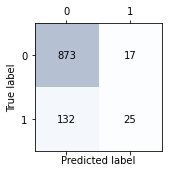

[[873  17]
 [132  25]]
No err
ループ
iriomote_ohara_route isigaki_dep 1
Labels counts in y[0 1]: [5486  858]
Labels counts in y_train[0 1]: [4389  686]
Labels counts in y_test[0 1]: [1097  172]
[LightGBM] [Info] Number of positive: 686, number of negative: 4389
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 5075, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135172 -> initscore=-1.855979
[LightGBM] [Info] Start training from score -1.855979
[20]	Train's auc: 0.919387	Test's auc: 0.863171


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[40]	Train's auc: 0.931397	Test's auc: 0.879629
[60]	Train's auc: 0.935676	Test's auc: 0.884246
[80]	Train's auc: 0.936857	Test's auc: 0.885947
[100]	Train's auc: 0.938074	Test's auc: 0.885306
0.8699763593380615


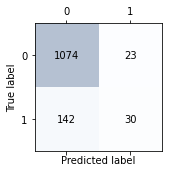

[[1074   23]
 [ 142   30]]
No err
ループ
iriomote_ohara_route isigaki_dep 2
Labels counts in y[0 1]: [5475  848]
Labels counts in y_train[0 1]: [4380  678]
Labels counts in y_test[0 1]: [1095  170]
[LightGBM] [Info] Number of positive: 678, number of negative: 4380
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 5058, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.134045 -> initscore=-1.865657
[LightGBM] [Info] Start training from score -1.865657
[20]	Train's auc: 0.924	Test's auc: 0.874145
[40]	Train's auc: 0.935748	Test's auc: 0.88393


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.939719	Test's auc: 0.887814
[80]	Train's auc: 0.941159	Test's auc: 0.88754
[100]	Train's auc: 0.942647	Test's auc: 0.890688
0.8679841897233201


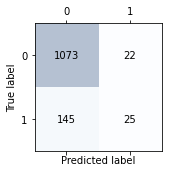

[[1073   22]
 [ 145   25]]
No err
ループ
iriomote_ohara_route isigaki_dep 3
Labels counts in y[0 1]: [5404  852]
Labels counts in y_train[0 1]: [4323  681]
Labels counts in y_test[0 1]: [1081  171]
[LightGBM] [Info] Number of positive: 681, number of negative: 4323
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 5004, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.136091 -> initscore=-1.848143
[LightGBM] [Info] Start training from score -1.848143
[20]	Train's auc: 0.91957	Test's auc: 0.864861
[40]	Train's auc: 0.930778	Test's auc: 0.881702
[60]	Train's auc: 0.936247	Test's auc: 0.888307


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.937201	Test's auc: 0.888242
[100]	Train's auc: 0.93832	Test's auc: 0.889124
0.8650159744408946


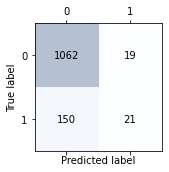

[[1062   19]
 [ 150   21]]
No err
ループ
iriomote_ohara_route isigaki_dep 4
Labels counts in y[0 1]: [5380  810]
Labels counts in y_train[0 1]: [4304  648]
Labels counts in y_test[0 1]: [1076  162]
[LightGBM] [Info] Number of positive: 648, number of negative: 4304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 4952, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130856 -> initscore=-1.893409
[LightGBM] [Info] Start training from score -1.893409
[20]	Train's auc: 0.925373	Test's auc: 0.85869
[40]	Train's auc: 0.934612	Test's auc: 0.874355


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.939001	Test's auc: 0.881772
[80]	Train's auc: 0.93989	Test's auc: 0.884778
[100]	Train's auc: 0.940509	Test's auc: 0.884753
0.875605815831987


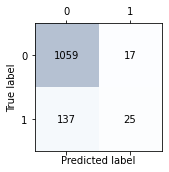

[[1059   17]
 [ 137   25]]
No err
ループ
iriomote_ohara_route isigaki_dep 5
Labels counts in y[0 1]: [5302  817]
Labels counts in y_train[0 1]: [4241  654]
Labels counts in y_test[0 1]: [1061  163]
[LightGBM] [Info] Number of positive: 654, number of negative: 4241
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 4895, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.133606 -> initscore=-1.869447
[LightGBM] [Info] Start training from score -1.869447
[20]	Train's auc: 0.920958	Test's auc: 0.881545
[40]	Train's auc: 0.929002	Test's auc: 0.889513
[60]	Train's auc: 0.933368	Test's auc: 0.893242


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.935387	Test's auc: 0.896336
[100]	Train's auc: 0.936275	Test's auc: 0.896104
0.8799019607843137


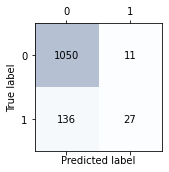

[[1050   11]
 [ 136   27]]
No err
ループ
iriomote_ohara_route isigaki_dep 6
Labels counts in y[0 1]: [5249  798]
Labels counts in y_train[0 1]: [4199  638]
Labels counts in y_test[0 1]: [1050  160]
[LightGBM] [Info] Number of positive: 638, number of negative: 4199
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 4837, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.131900 -> initscore=-1.884263
[LightGBM] [Info] Start training from score -1.884263
[20]	Train's auc: 0.928418	Test's auc: 0.870693
[40]	Train's auc: 0.938079	Test's auc: 0.879313
[60]	Train's auc: 0.94074	Test's auc: 0.887545


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.942433	Test's auc: 0.889658
[100]	Train's auc: 0.943108	Test's auc: 0.888527
0.8743801652892562


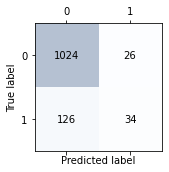

[[1024   26]
 [ 126   34]]
No err
ループ
iriomote_ohara_route isigaki_dep 7
Labels counts in y[0 1]: [5184  798]
Labels counts in y_train[0 1]: [4147  638]
Labels counts in y_test[0 1]: [1037  160]
[LightGBM] [Info] Number of positive: 638, number of negative: 4147
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 691
[LightGBM] [Info] Number of data points in the train set: 4785, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.133333 -> initscore=-1.871802
[LightGBM] [Info] Start training from score -1.871802
[20]	Train's auc: 0.927468	Test's auc: 0.844042
[40]	Train's auc: 0.935429	Test's auc: 0.857097
[60]	Train's auc: 0.938804	Test's auc: 0.859369


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.940666	Test's auc: 0.862856
[100]	Train's auc: 0.941421	Test's auc: 0.86476
0.8721804511278195


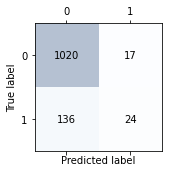

[[1020   17]
 [ 136   24]]
No err
ループ
iriomote_ohara_route isigaki_dep 8
Labels counts in y[0 1]: [5091  823]
Labels counts in y_train[0 1]: [4073  658]
Labels counts in y_test[0 1]: [1018  165]
[LightGBM] [Info] Number of positive: 658, number of negative: 4073
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 4731, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139083 -> initscore=-1.822930
[LightGBM] [Info] Start training from score -1.822930
[20]	Train's auc: 0.916932	Test's auc: 0.832461
[40]	Train's auc: 0.925827	Test's auc: 0.846812


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.930873	Test's auc: 0.851456
[80]	Train's auc: 0.932892	Test's auc: 0.853885
[100]	Train's auc: 0.934015	Test's auc: 0.85698
0.8622147083685545


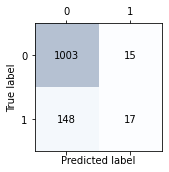

[[1003   15]
 [ 148   17]]
No err
ループ
iriomote_ohara_route isigaki_dep 9
Labels counts in y[0 1]: [5058  786]
Labels counts in y_train[0 1]: [4046  629]
Labels counts in y_test[0 1]: [1012  157]
[LightGBM] [Info] Number of positive: 629, number of negative: 4046
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 4675, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.134545 -> initscore=-1.861353
[LightGBM] [Info] Start training from score -1.861353
[20]	Train's auc: 0.915516	Test's auc: 0.863772
[40]	Train's auc: 0.929934	Test's auc: 0.881259
[60]	Train's auc: 0.933609	Test's auc: 0.886074


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.935558	Test's auc: 0.889227
[100]	Train's auc: 0.936733	Test's auc: 0.889825
0.874251497005988


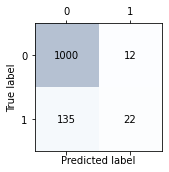

[[1000   12]
 [ 135   22]]
No err
ループ
iriomote_ohara_route ohara_dep 1
Labels counts in y[0 1]: [6157  859]
Labels counts in y_train[0 1]: [4925  687]
Labels counts in y_test[0 1]: [1232  172]
[LightGBM] [Info] Number of positive: 687, number of negative: 4925
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 5612, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122416 -> initscore=-1.969745
[LightGBM] [Info] Start training from score -1.969745
[20]	Train's auc: 0.923116	Test's auc: 0.896854
[40]	Train's auc: 0.933527	Test's auc: 0.907246
[60]	Train's auc: 0.937738	Test's auc: 0.909317


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.939006	Test's auc: 0.91095
[100]	Train's auc: 0.940243	Test's auc: 0.910917
0.8853276353276354


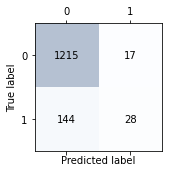

[[1215   17]
 [ 144   28]]
No err
ループ
iriomote_ohara_route ohara_dep 2
Labels counts in y[0 1]: [6141  849]
Labels counts in y_train[0 1]: [4913  679]
Labels counts in y_test[0 1]: [1228  170]
[LightGBM] [Info] Number of positive: 679, number of negative: 4913
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 5592, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121423 -> initscore=-1.979019
[LightGBM] [Info] Start training from score -1.979019
[20]	Train's auc: 0.922541	Test's auc: 0.867961
[40]	Train's auc: 0.939434	Test's auc: 0.88498
[60]	Train's auc: 0.943943	Test's auc: 0.889033


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.945496	Test's auc: 0.89184
[100]	Train's auc: 0.947064	Test's auc: 0.893421
0.8834048640915594


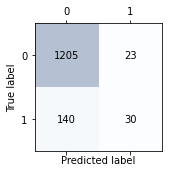

[[1205   23]
 [ 140   30]]
No err
ループ
iriomote_ohara_route ohara_dep 3
Labels counts in y[0 1]: [6065  853]
Labels counts in y_train[0 1]: [4852  682]
Labels counts in y_test[0 1]: [1213  171]
[LightGBM] [Info] Number of positive: 682, number of negative: 4852
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 5534, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123238 -> initscore=-1.962117
[LightGBM] [Info] Start training from score -1.962117
[20]	Train's auc: 0.918631	Test's auc: 0.862178
[40]	Train's auc: 0.932911	Test's auc: 0.874496
[60]	Train's auc: 0.938245	Test's auc: 0.884909


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.940125	Test's auc: 0.887276
[100]	Train's auc: 0.941084	Test's auc: 0.890142
0.8807803468208093


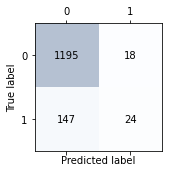

[[1195   18]
 [ 147   24]]
No err
ループ
iriomote_ohara_route ohara_dep 4
Labels counts in y[0 1]: [6034  810]
Labels counts in y_train[0 1]: [4827  648]
Labels counts in y_test[0 1]: [1207  162]
[LightGBM] [Info] Number of positive: 648, number of negative: 4827
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 5475, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118356 -> initscore=-2.008090
[LightGBM] [Info] Start training from score -2.008090
[20]	Train's auc: 0.926349	Test's auc: 0.894159
[40]	Train's auc: 0.937662	Test's auc: 0.911491


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.941438	Test's auc: 0.914595
[80]	Train's auc: 0.943146	Test's auc: 0.91548
[100]	Train's auc: 0.94415	Test's auc: 0.916171
0.8802045288531775


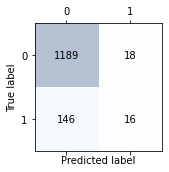

[[1189   18]
 [ 146   16]]
No err
ループ
iriomote_ohara_route ohara_dep 5
Labels counts in y[0 1]: [5946  818]
Labels counts in y_train[0 1]: [4757  654]
Labels counts in y_test[0 1]: [1189  164]
[LightGBM] [Info] Number of positive: 654, number of negative: 4757
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 5411, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120865 -> initscore=-1.984265
[LightGBM] [Info] Start training from score -1.984265
[20]	Train's auc: 0.926267	Test's auc: 0.878705
[40]	Train's auc: 0.936245	Test's auc: 0.888069


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.94007	Test's auc: 0.893172
[80]	Train's auc: 0.94194	Test's auc: 0.894357
[100]	Train's auc: 0.94308	Test's auc: 0.897839
0.8876570583887657


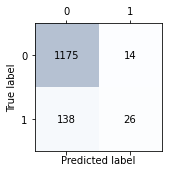

[[1175   14]
 [ 138   26]]
No err
ループ
iriomote_ohara_route ohara_dep 6
Labels counts in y[0 1]: [5883  799]
Labels counts in y_train[0 1]: [4706  639]
Labels counts in y_test[0 1]: [1177  160]
[LightGBM] [Info] Number of positive: 639, number of negative: 4706
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 5345, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119551 -> initscore=-1.996689
[LightGBM] [Info] Start training from score -1.996689
[20]	Train's auc: 0.926087	Test's auc: 0.869985
[40]	Train's auc: 0.937806	Test's auc: 0.886324
[60]	Train's auc: 0.941122	Test's auc: 0.892892


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.942503	Test's auc: 0.893195
[100]	Train's auc: 0.943737	Test's auc: 0.89662
0.8818249813014211


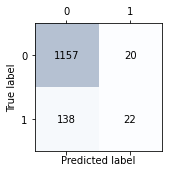

[[1157   20]
 [ 138   22]]
No err
ループ
iriomote_ohara_route ohara_dep 7
Labels counts in y[0 1]: [5813  799]
Labels counts in y_train[0 1]: [4650  639]
Labels counts in y_test[0 1]: [1163  160]
[LightGBM] [Info] Number of positive: 639, number of negative: 4650
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 5289, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120817 -> initscore=-1.984718
[LightGBM] [Info] Start training from score -1.984718
[20]	Train's auc: 0.928486	Test's auc: 0.861605
[40]	Train's auc: 0.937101	Test's auc: 0.87514
[60]	Train's auc: 0.941357	Test's auc: 0.883217


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.942905	Test's auc: 0.88298
[100]	Train's auc: 0.943317	Test's auc: 0.880831
0.8783068783068783


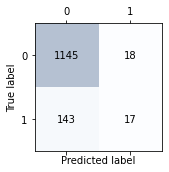

[[1145   18]
 [ 143   17]]
No err
ループ
iriomote_ohara_route ohara_dep 8
Labels counts in y[0 1]: [5714  824]
Labels counts in y_train[0 1]: [4571  659]
Labels counts in y_test[0 1]: [1143  165]
[LightGBM] [Info] Number of positive: 659, number of negative: 4571
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 5230, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126004 -> initscore=-1.936764
[LightGBM] [Info] Start training from score -1.936764
[20]	Train's auc: 0.913068	Test's auc: 0.875652
[40]	Train's auc: 0.927239	Test's auc: 0.890135
[60]	Train's auc: 0.932262	Test's auc: 0.89422


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.93468	Test's auc: 0.897651
[100]	Train's auc: 0.936085	Test's auc: 0.898409
0.8792048929663608


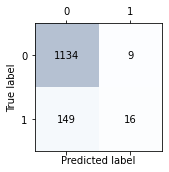

[[1134    9]
 [ 149   16]]
No err
ループ
iriomote_ohara_route ohara_dep 9
Labels counts in y[0 1]: [5673  787]
Labels counts in y_train[0 1]: [4538  630]
Labels counts in y_test[0 1]: [1135  157]
[LightGBM] [Info] Number of positive: 630, number of negative: 4538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 5168, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121904 -> initscore=-1.974522
[LightGBM] [Info] Start training from score -1.974522
[20]	Train's auc: 0.91693	Test's auc: 0.853512
[40]	Train's auc: 0.936162	Test's auc: 0.885712


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.94011	Test's auc: 0.894764
[80]	Train's auc: 0.941576	Test's auc: 0.895236
[100]	Train's auc: 0.942422	Test's auc: 0.89743
0.8831269349845201


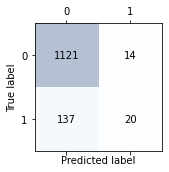

[[1121   14]
 [ 137   20]]
No err
ループ
hateruma_route isigaki_dep 1
Labels counts in y[0 1]: [6371  924]
Labels counts in y_train[0 1]: [5097  739]
Labels counts in y_test[0 1]: [1274  185]
[LightGBM] [Info] Number of positive: 739, number of negative: 5097
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 5836, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126628 -> initscore=-1.931109
[LightGBM] [Info] Start training from score -1.931109
[20]	Train's auc: 0.911805	Test's auc: 0.858967
[40]	Train's auc: 0.923337	Test's auc: 0.866744


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.927592	Test's auc: 0.866986
[80]	Train's auc: 0.929531	Test's auc: 0.868022
[100]	Train's auc: 0.930558	Test's auc: 0.867839
0.8800548320767649


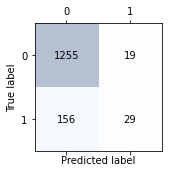

[[1255   19]
 [ 156   29]]
No err
ループ
hateruma_route isigaki_dep 2
Labels counts in y[0 1]: [6358  910]
Labels counts in y_train[0 1]: [5086  728]
Labels counts in y_test[0 1]: [1272  182]
[LightGBM] [Info] Number of positive: 728, number of negative: 5086
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 5814, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125215 -> initscore=-1.943946
[LightGBM] [Info] Start training from score -1.943946
[20]	Train's auc: 0.913117	Test's auc: 0.827359
[40]	Train's auc: 0.925812	Test's auc: 0.838839
[60]	Train's auc: 0.930562	Test's auc: 0.846108


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.932372	Test's auc: 0.847797
[100]	Train's auc: 0.93429	Test's auc: 0.849024
0.8817056396148556


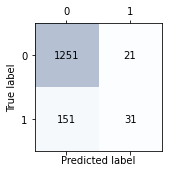

[[1251   21]
 [ 151   31]]
No err
ループ
hateruma_route isigaki_dep 3
Labels counts in y[0 1]: [6279  914]
Labels counts in y_train[0 1]: [5023  731]
Labels counts in y_test[0 1]: [1256  183]
[LightGBM] [Info] Number of positive: 731, number of negative: 5023
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 5754, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.127042 -> initscore=-1.927369
[LightGBM] [Info] Start training from score -1.927369
[20]	Train's auc: 0.908241	Test's auc: 0.84744
[40]	Train's auc: 0.922559	Test's auc: 0.857528


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.92778	Test's auc: 0.862605
[80]	Train's auc: 0.929661	Test's auc: 0.866799
[100]	Train's auc: 0.93114	Test's auc: 0.867443
0.8783877692842251


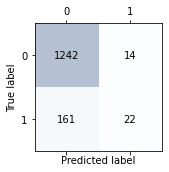

[[1242   14]
 [ 161   22]]
No err
ループ
hateruma_route isigaki_dep 4
Labels counts in y[0 1]: [6252  865]
Labels counts in y_train[0 1]: [5001  692]
Labels counts in y_test[0 1]: [1251  173]
[LightGBM] [Info] Number of positive: 692, number of negative: 5001
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 5693, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121553 -> initscore=-1.977807
[LightGBM] [Info] Start training from score -1.977807
[20]	Train's auc: 0.916766	Test's auc: 0.854165
[40]	Train's auc: 0.927241	Test's auc: 0.864689
[60]	Train's auc: 0.931032	Test's auc: 0.868565


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.931955	Test's auc: 0.867655
[100]	Train's auc: 0.933187	Test's auc: 0.867789
0.8785112359550562


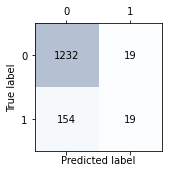

[[1232   19]
 [ 154   19]]
No err
ループ
hateruma_route isigaki_dep 5
Labels counts in y[0 1]: [6162  872]
Labels counts in y_train[0 1]: [4929  698]
Labels counts in y_test[0 1]: [1233  174]
[LightGBM] [Info] Number of positive: 698, number of negative: 4929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 5627, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124045 -> initscore=-1.954672
[LightGBM] [Info] Start training from score -1.954672
[20]	Train's auc: 0.907688	Test's auc: 0.859512
[40]	Train's auc: 0.919981	Test's auc: 0.87729
[60]	Train's auc: 0.924693	Test's auc: 0.88182


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.926032	Test's auc: 0.882892
[100]	Train's auc: 0.927907	Test's auc: 0.884556
0.8827292110874201


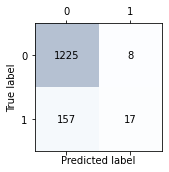

[[1225    8]
 [ 157   17]]
No err
ループ
hateruma_route isigaki_dep 6
Labels counts in y[0 1]: [6093  856]
Labels counts in y_train[0 1]: [4874  685]
Labels counts in y_test[0 1]: [1219  171]
[LightGBM] [Info] Number of positive: 685, number of negative: 4874
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 5559, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.123224 -> initscore=-1.962251
[LightGBM] [Info] Start training from score -1.962251
[20]	Train's auc: 0.912387	Test's auc: 0.861611
[40]	Train's auc: 0.924212	Test's auc: 0.878095
[60]	Train's auc: 0.92809	Test's auc: 0.881383


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.930016	Test's auc: 0.882751
[100]	Train's auc: 0.931152	Test's auc: 0.886469
0.8827338129496403


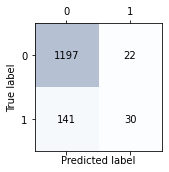

[[1197   22]
 [ 141   30]]
No err
ループ
hateruma_route isigaki_dep 7
Labels counts in y[0 1]: [6017  859]
Labels counts in y_train[0 1]: [4813  687]
Labels counts in y_test[0 1]: [1204  172]
[LightGBM] [Info] Number of positive: 687, number of negative: 4813
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 5500, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124909 -> initscore=-1.946742
[LightGBM] [Info] Start training from score -1.946742
[20]	Train's auc: 0.906306	Test's auc: 0.845703
[40]	Train's auc: 0.9163	Test's auc: 0.860241


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.922299	Test's auc: 0.864379
[80]	Train's auc: 0.924227	Test's auc: 0.866146
[100]	Train's auc: 0.925685	Test's auc: 0.868083
0.875


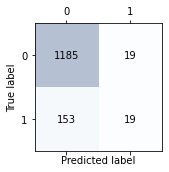

[[1185   19]
 [ 153   19]]
No err
ループ
hateruma_route isigaki_dep 8
Labels counts in y[0 1]: [5912  887]
Labels counts in y_train[0 1]: [4729  710]
Labels counts in y_test[0 1]: [1183  177]
[LightGBM] [Info] Number of positive: 710, number of negative: 4729
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 5439, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130539 -> initscore=-1.896204
[LightGBM] [Info] Start training from score -1.896204
[20]	Train's auc: 0.90206	Test's auc: 0.855803
[40]	Train's auc: 0.913545	Test's auc: 0.871539
[60]	Train's auc: 0.918618	Test's auc: 0.877397


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.921383	Test's auc: 0.878992
[100]	Train's auc: 0.921951	Test's auc: 0.882111
0.875


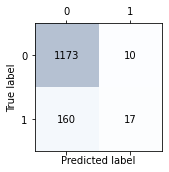

[[1173   10]
 [ 160   17]]
No err
ループ
hateruma_route isigaki_dep 9
Labels counts in y[0 1]: [5872  846]
Labels counts in y_train[0 1]: [4697  677]
Labels counts in y_test[0 1]: [1175  169]
[LightGBM] [Info] Number of positive: 677, number of negative: 4697
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 5374, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125977 -> initscore=-1.937008
[LightGBM] [Info] Start training from score -1.937008
[20]	Train's auc: 0.906695	Test's auc: 0.867929
[40]	Train's auc: 0.921192	Test's auc: 0.880488


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.926154	Test's auc: 0.883586
[80]	Train's auc: 0.927392	Test's auc: 0.882689
[100]	Train's auc: 0.928552	Test's auc: 0.883087
0.8787202380952381


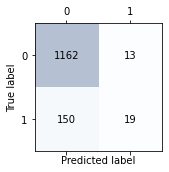

[[1162   13]
 [ 150   19]]
No err
ループ
hateruma_route hateruma_dep 1
Labels counts in y[0 1]: [6578  987]
Labels counts in y_train[0 1]: [5262  790]
Labels counts in y_test[0 1]: [1316  197]
[LightGBM] [Info] Number of positive: 790, number of negative: 5262
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 6052, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130535 -> initscore=-1.896234
[LightGBM] [Info] Start training from score -1.896234
[20]	Train's auc: 0.899256	Test's auc: 0.871941
[40]	Train's auc: 0.910459	Test's auc: 0.880913
[60]	Train's auc: 0.914682	Test's auc: 0.883762


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.916251	Test's auc: 0.884315
[100]	Train's auc: 0.917393	Test's auc: 0.886028
0.8790482485128883


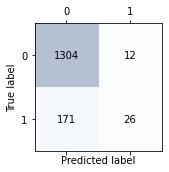

[[1304   12]
 [ 171   26]]
No err
ループ
hateruma_route hateruma_dep 2
Labels counts in y[0 1]: [6566  971]
Labels counts in y_train[0 1]: [5252  777]
Labels counts in y_test[0 1]: [1314  194]
[LightGBM] [Info] Number of positive: 777, number of negative: 5252
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 703
[LightGBM] [Info] Number of data points in the train set: 6029, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.128877 -> initscore=-1.910924
[LightGBM] [Info] Start training from score -1.910924
[20]	Train's auc: 0.903607	Test's auc: 0.853671
[40]	Train's auc: 0.91682	Test's auc: 0.862092


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.92096	Test's auc: 0.864334
[80]	Train's auc: 0.92254	Test's auc: 0.866774
[100]	Train's auc: 0.923919	Test's auc: 0.865981
0.876657824933687


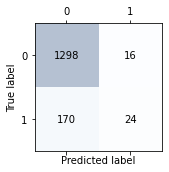

[[1298   16]
 [ 170   24]]
No err
ループ
hateruma_route hateruma_dep 3
Labels counts in y[0 1]: [6483  976]
Labels counts in y_train[0 1]: [5186  781]
Labels counts in y_test[0 1]: [1297  195]
[LightGBM] [Info] Number of positive: 781, number of negative: 5186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 702
[LightGBM] [Info] Number of data points in the train set: 5967, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130887 -> initscore=-1.893143
[LightGBM] [Info] Start training from score -1.893143
[20]	Train's auc: 0.89771	Test's auc: 0.823994
[40]	Train's auc: 0.913208	Test's auc: 0.845013


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.919328	Test's auc: 0.850928
[80]	Train's auc: 0.92169	Test's auc: 0.858328
[100]	Train's auc: 0.922594	Test's auc: 0.858561
0.8693029490616622


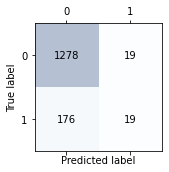

[[1278   19]
 [ 176   19]]
No err
ループ
hateruma_route hateruma_dep 4
Labels counts in y[0 1]: [6460  920]
Labels counts in y_train[0 1]: [5168  736]
Labels counts in y_test[0 1]: [1292  184]
[LightGBM] [Info] Number of positive: 736, number of negative: 5168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 5904, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.124661 -> initscore=-1.949011
[LightGBM] [Info] Start training from score -1.949011
[20]	Train's auc: 0.904022	Test's auc: 0.811366
[40]	Train's auc: 0.917665	Test's auc: 0.821456


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.922892	Test's auc: 0.829915
[80]	Train's auc: 0.925266	Test's auc: 0.836885
[100]	Train's auc: 0.925847	Test's auc: 0.8367
0.8760162601626016


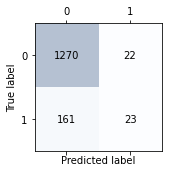

[[1270   22]
 [ 161   23]]
No err
ループ
hateruma_route hateruma_dep 5
Labels counts in y[0 1]: [6369  926]
Labels counts in y_train[0 1]: [5095  741]
Labels counts in y_test[0 1]: [1274  185]
[LightGBM] [Info] Number of positive: 741, number of negative: 5095
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 5836, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126971 -> initscore=-1.928014
[LightGBM] [Info] Start training from score -1.928014
[20]	Train's auc: 0.897911	Test's auc: 0.845961
[40]	Train's auc: 0.911693	Test's auc: 0.862164
[60]	Train's auc: 0.916793	Test's auc: 0.867094


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.919094	Test's auc: 0.869581
[100]	Train's auc: 0.920628	Test's auc: 0.870514
0.8793694311172036


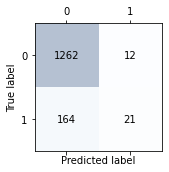

[[1262   12]
 [ 164   21]]
No err
ループ
hateruma_route hateruma_dep 6
Labels counts in y[0 1]: [6295  912]
Labels counts in y_train[0 1]: [5035  730]
Labels counts in y_test[0 1]: [1260  182]
[LightGBM] [Info] Number of positive: 730, number of negative: 5035
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 5765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.126626 -> initscore=-1.931124
[LightGBM] [Info] Start training from score -1.931124
[20]	Train's auc: 0.909735	Test's auc: 0.839698
[40]	Train's auc: 0.920455	Test's auc: 0.848456


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.924338	Test's auc: 0.850896
[80]	Train's auc: 0.926391	Test's auc: 0.853356
[100]	Train's auc: 0.927654	Test's auc: 0.85367
0.8717059639389736


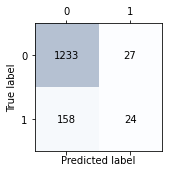

[[1233   27]
 [ 158   24]]
No err
ループ
hateruma_route hateruma_dep 7
Labels counts in y[0 1]: [6215  917]
Labels counts in y_train[0 1]: [4971  734]
Labels counts in y_test[0 1]: [1244  183]
[LightGBM] [Info] Number of positive: 734, number of negative: 4971
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 5705, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.128659 -> initscore=-1.912867
[LightGBM] [Info] Start training from score -1.912867
[20]	Train's auc: 0.896532	Test's auc: 0.834447
[40]	Train's auc: 0.908554	Test's auc: 0.844739
[60]	Train's auc: 0.9133	Test's auc: 0.847421

/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[80]	Train's auc: 0.91581	Test's auc: 0.851124
[100]	Train's auc: 0.916875	Test's auc: 0.85115
0.8717589348283111


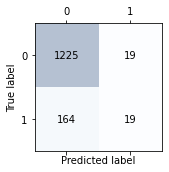

[[1225   19]
 [ 164   19]]
No err
ループ
hateruma_route hateruma_dep 8
Labels counts in y[0 1]: [6107  945]
Labels counts in y_train[0 1]: [4885  756]
Labels counts in y_test[0 1]: [1222  189]
[LightGBM] [Info] Number of positive: 756, number of negative: 4885
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 701
[LightGBM] [Info] Number of data points in the train set: 5641, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.134019 -> initscore=-1.865883
[LightGBM] [Info] Start training from score -1.865883
[20]	Train's auc: 0.890365	Test's auc: 0.843404
[40]	Train's auc: 0.90479	Test's auc: 0.857812


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[60]	Train's auc: 0.909876	Test's auc: 0.864116
[80]	Train's auc: 0.912557	Test's auc: 0.865095
[100]	Train's auc: 0.913823	Test's auc: 0.866311
0.8710134656272147


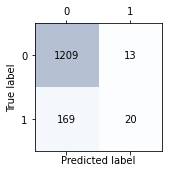

[[1209   13]
 [ 169   20]]
No err
ループ
hateruma_route hateruma_dep 9
Labels counts in y[0 1]: [6067  901]
Labels counts in y_train[0 1]: [4853  721]
Labels counts in y_test[0 1]: [1214  180]
[LightGBM] [Info] Number of positive: 721, number of negative: 4853
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 699
[LightGBM] [Info] Number of data points in the train set: 5574, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.129351 -> initscore=-1.906713
[LightGBM] [Info] Start training from score -1.906713
[20]	Train's auc: 0.898976	Test's auc: 0.865687
[40]	Train's auc: 0.911689	Test's auc: 0.873735
[60]	Train's auc: 0.917013	Test's auc: 0.877588


/Users/nosuke/.pyenv/versions/3.7.3/lib/python3.7/site-packages/lightgbm/callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[80]	Train's auc: 0.919522	Test's auc: 0.877959
[100]	Train's auc: 0.920716	Test's auc: 0.880283
0.8751793400286944


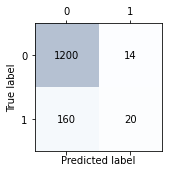

[[1200   14]
 [ 160   20]]
No err
ループ


In [45]:
eng_name_dic = {
    "taketomi_route" : ["isigaki_dep", "taketomi_dep"],
    "kurosima_route" : ["isigaki_dep", "kurosima_dep"],
    "kohama_route" : ["isigaki_dep", "kohama_dep"],
    "iriomote_uehara_route" : ["isigaki_dep", "uehara_dep"],
    "hatoma_route" : ["isigaki_dep", "hatoma_dep"],
    "iriomote_ohara_route" : ["isigaki_dep", "ohara_dep"],
   "hateruma_route" : ["isigaki_dep", "hateruma_dep"]
                                           } 
path_txt = "../data/result_value/1_30_value.txt"

for route_name,deps in eng_name_dic.items():
    for dep in deps:
        for days_ago in range(1,10):
            try:
                print(route_name,dep,str(days_ago))
                main(route_name,dep,days_ago,path_txt)
            except Exception as e:
                #print(e)
                err = True
                result_txt(path_txt,route_name,dep,days_ago,confmat,y_test, y_pred,err)
            print("ループ")
